In [ ]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse

from tqdm.notebook import tqdm
import typing as tp
import numpy.typing as ntp

## Dataset

In [ ]:
import json
from pathlib import Path

def load_multiwoz(split, path='/home/admin/research/data/multiwoz/data/MultiWOZ_2.2', order=None):
    data_dir = Path(path) / split
    data = []
    data_parts = list(data_dir.iterdir())
    if order:
        data_parts = [data_dir / order_item for order_item in order]
    for data_part in tqdm(data_parts):
        print(data_part)
        with data_part.open() as f:
            data.extend(json.load(f))
    return data

In [3]:
from itertools import accumulate

class Utterance:
    def __init__(self, utterance: str, speaker: str, turn_id: str, **meta: tp.Any):
        self.utterance = utterance
        self.speaker = speaker
        self.turn_id = turn_id
        self.meta = meta
    
    def __str__(self) -> str:
        return self.utterance
    
    def __repr__(self) -> str:
        return f"[{self.turn_id:>2}] {self.speaker:>8}: \"{self.utterance}\""
    
    @classmethod
    def from_multiwoz_v22(cls, utterance: tp.Dict[str, tp.Any]) -> 'Utterance':
        return cls(**utterance)
    

class Dialogue:
    def __init__(self, utterances: tp.List[Utterance], dialogue_id: str, **meta: tp.Any):
        self.utterances = utterances
        self.dialogue_id = dialogue_id
        self.meta = meta
    
    def __len__(self) -> int:
        return len(self.utterances)
    
    def __str__(self) -> str:
        return "\n".join(str(utt) for utt in self.utterances)
    
    def __repr__(self) -> str:
        return f"[{self.dialogue_id}]\n" + '\n'.join(repr(utt) for utt in self.utterances)
    
    def __getitem__(self, i) -> Utterance:
        return self.utterances[i]
    
    def __iter__(self) -> tp.Iterator[Utterance]:
        return iter(self.utterances)
        
    
    @classmethod
    def from_multiwoz_v22(cls, dialogue: tp.Dict[str, tp.Any]) -> 'Dialogue':
        utterances = [Utterance.from_multiwoz_v22(utt) for utt in dialogue['turns']]
        dialogue_id = dialogue['dialogue_id']
        meta = {key: val for key, val in dialogue.items() if key not in ['turns', 'dialogue_id']}
        return cls(utterances=utterances, dialogue_id=dialogue_id, **meta)


class DialogueDataset(list):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.utterances = [utt.utterance for dialog in self for utt in dialog]
        
        self._dialogue_start = list(accumulate([0] + [len(dialogue) for dialogue in self]))
        
        self._utt_dialogue_id = [0] * len(self.utterances)
        self._utt_id = [0] * len(self.utterances)
        for d_start in self._dialogue_start[1:-1]:
            self._utt_dialogue_id[d_start] = 1
        current_utt_id = 0
        for i in range(len(self._utt_id)):
            if self._utt_dialogue_id[i] == 1:
                current_utt_id = 0
            self._utt_id[i] = current_utt_id
            current_utt_id += 1
        self._utt_dialogue_id = list(accumulate(self._utt_dialogue_id))
        
        self._dial_id_mapping = {dialogue.dialogue_id: i 
                                for i, dialogue in enumerate(self)}
    
    def get_dialogue_by_idx(self, idx: int) -> Dialogue:
        udi = self._utt_dialogue_id[idx]
        return self[udi]
    
    def get_utterance_by_idx(self, idx: int) -> Utterance:
        udi = self._utt_dialogue_id[idx]
        ui = self._utt_id[idx]
        return self[udi][ui]
    
    def get_dialog_start_idx(self, dialogue: 'Dialog') -> int:
        dialogue_idx = self._dial_id_mapping[dialogue.dialogue_id]
        d_start = self._dialogue_start[dialogue_idx]
        return d_start
    
    @classmethod
    def from_miltiwoz_v22(cls, multiwoz_v22: tp.List[tp.Dict[str, tp.Any]]) -> 'DialogueDataset':
        dialogues = [Dialogue.from_multiwoz_v22(dialog) for dialog in multiwoz_v22]
        return cls(dialogues)

class Subset(DialogueDataset):
    def __init__(self, dialogues: DialogueDataset, subset: tp.Iterable):
        subset_dialogues = [dialogues[idx] for idx in subset]
        super().__init__(subset_dialogues)

In [4]:
test = DialogueDataset.from_miltiwoz_v22(load_multiwoz('test'))
val = DialogueDataset.from_miltiwoz_v22(load_multiwoz('dev'))
train = DialogueDataset.from_miltiwoz_v22(load_multiwoz('train', order=['dialogues_001.json', 'dialogues_011.json', 'dialogues_007.json', 'dialogues_010.json', 'dialogues_017.json', 'dialogues_005.json', 'dialogues_015.json', 'dialogues_012.json', 'dialogues_016.json', 'dialogues_013.json', 'dialogues_004.json', 'dialogues_009.json', 'dialogues_003.json', 'dialogues_006.json', 'dialogues_008.json', 'dialogues_002.json', 'dialogues_014.json']))

  0%|          | 0/2 [00:00<?, ?it/s]

/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/test/dialogues_001.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/test/dialogues_002.json


  0%|          | 0/2 [00:00<?, ?it/s]

/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/dev/dialogues_001.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/dev/dialogues_002.json


  0%|          | 0/17 [00:00<?, ?it/s]

/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_001.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_011.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_007.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_010.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_017.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_005.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_015.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_012.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_016.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_013.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_004.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_009.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialo

## Embedders

### Interface

In [5]:
from abc import ABC, abstractmethod
from tqdm.notebook import tqdm

class OneViewEmbedder(ABC):
    def __init__(self, config: tp.Optional[tp.Any] = None):
        self.config = config
    
    @abstractmethod
    def encode_dialogue(self, dialogue: Dialogue):
        return np.zeros((len(dialogue), 1), dtype=np.int32)
    
    def encode_dataset(self, dialogues: DialogueDataset):
        return np.concatenate([self.encode_dialogue(dialogue) for dialogue in tqdm(dialogues)], axis=0)
    
    def encode_new_dialogue(self, dialogue: Dialogue):
        return self.encode_dialogue(dialogue)
    
    def encode_new_dataset(self, dialogues: DialogueDataset):
        return np.concatenate([self.encode_new_dialogue(dialogue) for dialogue in tadm(dialogues)], axis=0)

### TFIDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

class TFIDFEmbedder(OneViewEmbedder):
    def __init__(self, **config: tp.Any):
        self.config = config
        self.embeddings = None
        
    def fit(self, dialogues: DialogueDataset):
        self.tfidf = TfidfVectorizer(**self.config)
        self.dialogues = dialogues
        self.embeddings = self.tfidf.fit_transform(self.dialogues.utterances)
    
    def encode_dialogue(self, dialogue: Dialogue) -> scipy.sparse.csr_matrix:
        assert self.embeddings is not None, "TFIDFEmbedder must be fitted before encode"
        d_start = self.dialogues.get_dialog_start_idx(dialogue)
        return self.embeddings[d_start: d_start + len(dialogue)]
    
    def encode_dataset(self, dialogues: DialogueDataset) -> scipy.sparse.csr_matrix:
        assert self.embeddings is not None, "TFIDFEmbedder must be fitted before encode"
        return self.embeddings
    
    def get_utterance_keywords(self, idx):
        assert self.embeddings is not None, "TFIDFEmbedder must be fitted"
        feats = self.embeddings[idx].nonzero()[1]
        return [self.tfidf.get_feature_names()[feat] for feat in feats]
    
    def encode_new_dialogue(self, dialogue: Dialogue):
        new_embeddings = self.tfidf.transform([utt.utterance for utt in dialogue])
        return new_embeddings
    
    def encode_new_dataset(self, dialogues: DialogueDataset):
        new_embeddings = self.tfidf.transform(dialogues.utterances)
        return new_embeddings

### Sentence Embeddings

In [7]:
from sentence_transformers import SentenceTransformer

class SentenceEmbedder(OneViewEmbedder):
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', **config: tp.Any):
        self.config = config
        self.model = SentenceTransformer(model_name, **config)
    
    def encode_dialogue(self, dialogue: Dialogue) -> np.array:
        utterances = [utt.utterance for utt in dialogue]
        embeddings = self.model.encode(utterances)
        return embeddings
    
    def encode_dataset(self, dialogues: DialogueDataset) -> np.array:
        return self.model.encode(dialogues.utterances)
    
    def encode_new_dialogue(self, dialogue: Dialogue):
        return self.encode_dialogue(dialogue)
    
    def encode_new_dataset(self, dialogues: DialogueDataset):
        return self.encode_dataset(dialogues)

In [8]:
sentence_emb = SentenceEmbedder(device=0)
embeddings = sentence_emb.encode_dataset(train)
test_embeddings = sentence_emb.encode_new_dataset(test)
val_embeddings = sentence_emb.encode_new_dataset(val)

In [10]:
#np.save('sentence_bert_train_embeddings', embeddings)
#np.save('sentence_bert_test_embeddings', test_embeddings)
#np.save('sentence_bert_val_embeddings', val_embeddings)

### ConveRT

In [4]:
!wget http://files.deeppavlov.ai/alexaprize_data/convert_reddit_v2.8.tar.gz

--2022-03-23 16:23:44--  http://files.deeppavlov.ai/alexaprize_data/convert_reddit_v2.8.tar.gz
Resolving files.deeppavlov.ai (files.deeppavlov.ai)... 10.11.1.254
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|10.11.1.254|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1014155451 (967M) [application/octet-stream]
Saving to: 'convert_reddit_v2.8.tar.gz'

convert_reddit_v2.8 100%[===================>] 967.17M   339MB/s    in 2.9s    

2022-03-23 16:23:47 (339 MB/s) - 'convert_reddit_v2.8.tar.gz' saved [1014155451/1014155451]



In [5]:
!tar xzfv convert_reddit_v2.8.tar.gz

./
./replies_v6.pkl
./confidences_v3.npy
./replies_v4.pkl
./replies_v5.pkl
./convert/
./convert/assets/
./convert/variables/
./convert/variables/variables.data-00000-of-00002
./convert/variables/variables.index
./convert/variables/variables.data-00001-of-00002
./convert/saved_model.pb
./convert/tfhub_module.pb
./replies_v2.pkl
./replies_v3.pkl
./confidences_v2.npy


In [6]:
!ls

DialogGraphConstructing.ipynb  replies_v6.pkl
confidences_v2.npy	       sentence_bert_test_embeddings.npy
confidences_v3.npy	       sentence_bert_train_embeddings.npy
convert			       sentence_bert_val_embeddings.npy
convert_example.py	       test_convert_context.np.npy
convert_reddit_v2.8.tar.gz     test_convert_responses.np.npy
multiwoz		       train_convert_context.np.npy
replies_v2.pkl		       train_convert_responses.np.npy
replies_v3.pkl		       val_convert_context.np.npy
replies_v4.pkl		       val_convert_responses.np.npy
replies_v5.pkl


In [6]:
# tensorflow==1.14.0
# tensorflow_text==0.1.0
# tensorflow-hub==0.7.0
# wget http://files.deeppavlov.ai/alexaprize_data/convert_reddit_v2.8.tar.gz
# tar xzfv .....
# MODEL_PATH=........../convert_data/convert

import os

import tensorflow_hub as tfhub
import tensorflow as tf
import tensorflow_text
tf = tf.compat.v1

from tqdm.notebook import trange


tensorflow_text.__name__

# MODEL_PATH = os.getenv("MODEL_PATH")
MODEL_PATH = "convert"

sess = tf.InteractiveSession(graph=tf.Graph())

module = tfhub.Module(MODEL_PATH)


text_placeholder = tf.placeholder(dtype=tf.string, shape=[None])
extra_text_placeholder = tf.placeholder(dtype=tf.string, shape=[None])

# The encode_context signature now also takes the extra context.
context_encoding_tensor = module(
    {"context": text_placeholder, "extra_context": extra_text_placeholder}, signature="encode_context"
)


responce_text_placeholder = tf.placeholder(dtype=tf.string, shape=[None])

response_encoding_tensor = module(responce_text_placeholder, signature="encode_response")

sess.run(tf.tables_initializer())
sess.run(tf.global_variables_initializer())


def encode_context(dialogue_history):
    """Encode the dialogue context to the response ranking vector space.

    Args:
        dialogue_history: a list of strings, the dialogue history, in
            chronological order.
    """

    # The context is the most recent message in the history.
    context = dialogue_history[-1]

    extra_context = list(dialogue_history[:-1])
    extra_context.reverse()
    extra_context_feature = " ".join(extra_context)

    return sess.run(
        context_encoding_tensor,
        feed_dict={text_placeholder: [context], extra_text_placeholder: [extra_context_feature]},
    )[0]


def encode_dialogues(dialogues):
    histories = [" ".join(u.utterance for u in dialogue[:k][::-1]) 
                 for dialogue in dialogues 
                 for k in range(len(dialogue))]
    utterances = dialogues.utterances
    
    print(len(histories))
    print(len(utterances))
    
    parts = []
    step = 1000
    for i in trange(0, len(utterances), step):
        parts.append(sess.run(
            context_encoding_tensor,
            feed_dict={text_placeholder: utterances[i:i+step], 
                       extra_text_placeholder: histories[i:i+step]},
        )[0])
    return parts


def encode_responses(texts):
    return sess.run(response_encoding_tensor, feed_dict={responce_text_placeholder: texts})

2022-03-23 17:56:58.784859: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-23 17:56:58.819857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 17:56:58.852667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-03-23 17:56:58.854441: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you woul

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [7]:
tf.__version__

'2.8.0'

In [8]:
class ConvertEmbedder(OneViewEmbedder):
    def encode_dialogue(self, dialogue: Dialogue) -> np.array:
        utterances = [utt.utterance for utt in dialogue]
        embeddings = np.array([encode_context(utterances[:k]) for k in range(1, len(utterances) + 1)])
        return embeddings

    def encode_new_dialogue(self, dialogue: Dialogue):
        return self.encode_dialogue(dialogue)
    
    def encode_responses(self, utterances: tp.List[str]):
        return encode_responses(utterances)

In [9]:
utterances_histories = ["hi", "hi, how are you?"]
responses = ["fine", "how are you?", "what do you mean", "I'm quite good."]
context_encoding = encode_context(utterances_histories)
response_encodings = encode_responses(responses)
scores = context_encoding.dot(response_encodings.T)
print(scores)

[0.1785331  0.3307736  0.08666332 0.29019952]


In [11]:
convert_embedder = ConvertEmbedder()

In [11]:
val_convert = convert_embedder.encode_dataset(val)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
np.save("val_convert_context.np", val_convert)

In [13]:
test_convert = convert_embedder.encode_dataset(test)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
np.save("test_convert_context.np", test_convert)

In [ ]:
resp_val_convert = convert_embedder.encode_responses(val.utterances)
np.save("val_convert_responses.np", resp_val_convert)

2022-03-23 17:18:36.511948: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1782030336 exceeds 10% of free system memory.
2022-03-23 17:18:37.088477: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1782030336 exceeds 10% of free system memory.
2022-03-23 17:18:37.668988: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1782030336 exceeds 10% of free system memory.
2022-03-23 17:18:38.027645: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1782030336 exceeds 10% of free system memory.
2022-03-23 17:18:38.975756: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1782030336 exceeds 10% of free system memory.


In [ ]:
resp_test_convert = convert_embedder.encode_responses(test.utterances)
np.save("test_convert_responses.np", resp_test_convert)

In [ ]:
train_convert = convert_embedder.encode_dataset(train)
np.save("train_convert_context.np", train_convert)

In [ ]:
step = 1000

resp_train_convert = []

for i in trange(0, len(train.utterances), step):
    resp_train_convert.append(convert_embedder.encode_responses(train.utterances[i:i+step]))

resp_train_convert = np.concatenate(resp_train_convert, axis=0)
np.save("train_convert_responses.np", resp_train_convert)

In [ ]:
test_convert = np.load("test_convert_context.np.npy")
resp_test_convert = np.load("test_convert_responses.np.npy")

train_convert = np.load("train_convert_context.np.npy")
resp_train_convert = np.load("train_convert_responses.np.npy")

### Cached Embeddings

In [6]:
class CachedEmbeddings():
    def __init__(self, dialogues: DialogueDataset, embeddings: np.array, 
                 test_dialogues: DialogueDataset = None, test_embeddings: np.array = None):
        self.dialogues = dialogues
        self.embeddings = embeddings
        self.test_dialogues = test_dialogues
        self.test_embeddings = test_embeddings
    
    def encode_dialogue(self, dialogue: Dialogue) -> np.array:
        idx = self.dialogues.get_dialog_start_idx(dialogue)
        return self.embeddings[idx:idx + len(dialogue)]

    def encode_new_dialogue(self, dialogue: Dialogue):
        idx = self.test_dialogues.get_dialog_start_idx(dialogue)
        return self.test_embeddings[idx:idx + len(dialogue)]
    
    def encode_utterances(self, utts):
        return self.embeddings[utts]

In [8]:
test_convert = np.load("test_convert_context.np.npy")
resp_test_convert = np.load("test_convert_responses.np.npy")

train_convert = np.load("train_convert_context.np.npy")
resp_train_convert = np.load("train_convert_responses.np.npy")

In [9]:
cached_convert_context = CachedEmbeddings(train, train_convert, test, test_convert)
cached_convert_response = CachedEmbeddings(train, resp_train_convert, test, resp_test_convert)

### Universal Sentence Encoder

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

def embed(input):
    return model(input)

In [22]:
embed([train[100][0].utterance])

Tensor("strided_slice_1:0", shape=(512,), dtype=float32)


In [ ]:
from sentence_transformers import SentenceTransformer

class USEEmbedder(OneViewEmbedder):
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', **config: tp.Any):
        self.config = config
        self.model = SentenceTransformer(model_name, **config)
    
    def encode_dialogue(self, dialogue: Dialogue) -> np.array:
        utterances = [utt.utterance for utt in dialogue]
        embeddings = self.model.encode(utterances)
        return embeddings
    
    def encode_dataset(self, dialogues: DialogueDataset) -> np.array:
        return self.model.encode(dialogues.utterances)
    
    def encode_new_dialogue(self, dialogue: Dialogue):
        return self.encode_dialogue(dialogue)
    
    def encode_new_dataset(self, dialogues: DialogueDataset):
        return self.encode_dataset(dialogues)

### Comparision

In [ ]:
def print_most_similar(dialogues, embeddings, idx, k_most_similar=5):
    a = embeddings[idx]
    a = a / np.linalg.norm(a)
    similarities = np.dot(a, embeddings.T) / np.linalg.norm(embeddings, axis=-1)
    top = np.argsort(similarities)[::-1][1:k_most_similar+1]
    print(dialogues.utterances[idx])
    print()
    for utt in top:
        print(dialogues.utterances[utt])

#### Sentence BERT all-MiniLM-L6-v2

In [351]:
sent_emb_all_minilm_l6_v2 = SentenceEmbedder('all-MiniLM-L6-v2')

embeddings_all_minilm_l6_v2 = sent_emb_all_minilm_l6_v2.encode_dataset(train)

In [360]:
print_most_similar(train, embeddings_all_minilm_l6_v2, 42, 10)

We will be arriving on Sunday and will stay for 5 nights.

I need to stay for 5 nights. We'll be arriving on Monday.
We will arrive on Saturday and stay for four nights.
There will be 7 of us arriving Sunday. We will be staying 3 nights.
There will be 6 of us arriving on Sunday, and we need to stay for 4 nights.
We will be arriving on Friday and staying 3 nights.
Yes thanks. There will be 2 of us arriving for 5 nights on Sunday.
I'll be arriving on a Saturday and staying for 5 days.
The 7 of us will be arriving on Saturday and staying 4 nights.
Yes, please! 7 of us will be arriving on Wednesday, and we'd like to stay 5 nights.
Yes, please. There will be 7 of us arriving on Tuesday, and we're staying for 5 nights.


In [361]:
print_most_similar(train, embeddings_all_minilm_l6_v2, 43, 10)

Can you tell me how many guests will be staying in the room?

How many people will be staying in the room?
OK, and how many people will be staying in the room?
May I ask how many people will be staying in the room with you?
How many people will be staying at the hotel?
How many people will be staying at the hotel?
How many people will be staying at the hotel?
How many people will the room be for?
I can do that, but first, can you confirm how many guests will be staying?
I will need to know how many guests are staying and for how many nights
I'd be happy to book you a room. How many people will be staying, and for how many nights?


#### Sentence BERT all-mpnet-base-v2

In [363]:
sent_emb_all_mpnet_base_v2 = SentenceEmbedder('all-mpnet-base-v2')

embeddings_all_mpnet_base_v2 = sent_emb_all_mpnet_base_v2.encode_dataset(train)

In [364]:
print_most_similar(train, embeddings_all_mpnet_base_v2, 42, 10)

We will be arriving on Sunday and will stay for 5 nights.

We will be arriving on Friday and staying 3 nights.
We will be staying for five days.
We will be staying 2 nights starting on Tuesday.
We'll be arriving on Friday, and we'd like to stay for 2 nights.
I will be staying 5 nights starting from Saturday.
I will be staying 5 nights starting from Saturday.
I need to stay for 5 nights. We'll be arriving on Monday.
I'll be arriving on a Saturday and staying for 5 days.
We'll be coming in on Saturday and will be staying for three nights.
We want to arrive on Friday and stay 4 nights.


In [365]:
print_most_similar(train, embeddings_all_mpnet_base_v2, 43, 10)

Can you tell me how many guests will be staying in the room?

How many people will be staying in the room?
May I ask how many people will be staying in the room with you?
OK, and how many people will be staying in the room?
How many people will the room be for?
How many people will be staying at the hotel?
How many people will be staying at the hotel?
How many people will be staying at the hotel?
Can you please tell me how many people will be staying and for how many nights?
How many people will be staying there?
How many people would you like to book the room for?


#### ConveRT

In [8]:
test_convert = np.load("test_convert_context.np.npy")
resp_test_convert = np.load("test_convert_responses.np.npy")

train_convert = np.load("train_convert_context.np.npy")
resp_train_convert = np.load("train_convert_responses.np.npy")

In [9]:
print_most_similar(train, train_convert, 42, 10)

We will be arriving on Sunday and will stay for 5 nights.

We will be arriving on Friday and staying 3 nights.
We'll be coming in on Saturday and will be staying for three nights.
We will be staying 2 nights starting on Tuesday.
I'll be arriving on Saturday and staying 3 nights.
We want to arrive on Friday and stay 4 nights.
I'll be staying for 5 nights, starting on Friday.
We will be there for 4 nights.
We are arriving on Tuesday and want to stay 2 nights.
There will be 2 of us, and we're hoping to arrive on Thursday and stay for 3 nights.
There will be 7 of us arriving Sunday. We will be staying 3 nights.


In [10]:
print_most_similar(train, train_convert, 43, 10)

Can you tell me how many guests will be staying in the room?

Could you tell me how many people will be staying?
How many people will be staying?
How many people will be staying?
Okay great, so how many people will be staying and for how many nights?
How many people will be staying?
May I ask how many people will be staying in the room with you?
And how many people will be staying?
How many people will be staying?
Can you please tell me how many people will be staying and for how many nights?
Great! How many people will be staying?


## Clustering

### Interface

In [7]:
class Cluster:
    def __init__(self, cluster_id, utterances):
        self.id = cluster_id
        self.utterances = utterances
    
    def __getitem__(self, idx):
        return self.utterances[idx]
    
    def __iter__(self):
        return iter(self.utterances)
    
    def __len__(self):
        return len(self.utterances)

In [8]:
class OneViewClustering(ABC):
    def __init__(self):
        self.size = 1
        
    @abstractmethod
    def fit(embeddings: np.array) -> 'OneViewClustering':
        self.size = embeddings.shape[0]
        self.cluster = Cluster(0, np.arange(self.size))
        return self
    
    @abstractmethod
    def get_cluster(self, idx: int) -> Cluster:
        assert idx == 1
        return self.cluster[0]
    
    @abstractmethod
    def get_utterance_cluster(self, utt_idx: int) -> Cluster:
        return self.cluster[0]
    
    @abstractmethod
    def get_nclusters(self) -> int:
        return 1
        
    @abstractmethod
    def predict_cluster(self, embedding: np.array, 
                        utterance: tp.Optional[Utterance] = None, 
                        dialogue: tp.Optional[Dialogue] = None):
        return self.cluster[0]
    
    @abstractmethod
    def get_labels(self) -> np.array:
        return np.zeros(self.size)

In [9]:
from collections import Counter

def print_clustering(clustering, dialogues, max_utts=10):
    for i in range(clustering.get_nclusters()):
        cluster = clustering.get_cluster(i)

        print(f"Cluster #{i}: {len(cluster)} utterances")
        utt_step = (len(cluster) + max_utts - 1) // max_utts
        if utt_step > 0:
            print('\n'.join([dialogues.utterances[utt] for utt in cluster.utterances[::utt_step]]))
            print()
            print(Counter([dialogues.get_utterance_by_idx(utt).speaker for utt in cluster]))
        else:
            print('NO UTTERANCES')
        print('\n')

### BiClustering

In [12]:
class BiCluster(Cluster):
    def __init__(self, cluster_id, utterances, words):
        super().__init__(cluster_id, utterances)
        self.words = words

In [13]:
from sklearn.cluster import SpectralCoclustering

class BiClustering(OneViewClustering):
    def __init__(self, n_clusters=15, svd_method="arpack", random_state=42, **config):
        self.n_clusters = n_clusters
        self.svd_method = svd_method
        self.random_state = random_state
        self.config = config
        
        self.cocluster = SpectralCoclustering(
            n_clusters=self.n_clusters, 
            svd_method=self.svd_method, 
            random_state=self.random_state,
            **config
        )
        self.fitted = False
    
    def fit(self, embeddings: np.array) -> 'BiClustering':
        mask = np.array(embeddings.sum(axis=1) > 0).reshape(-1)
        
        word_mask = np.array(embeddings[mask].sum(axis=0) > 0).reshape(-1)

        self.filtered_mapping = {}
        for orig, mapped in enumerate(accumulate(mask.astype(np.int32))):
            if mapped > 0 and mapped - 1 not in self.filtered_mapping:
                self.filtered_mapping[mapped - 1] = orig
        
        self.words_mapping = {}
        for orig, mapped in enumerate(accumulate(word_mask.astype(np.int32))):
            if mapped > 0 and mapped - 1 not in self.words_mapping:
                self.words_mapping[mapped - 1] = orig
        
        self.cocluster.fit(embeddings[mask].T[word_mask].T)
        
        self.cluster_by_utt = {}
        self.clusters = []
        for cluster_id in range(self.n_clusters):
            utts, words = self.cocluster.get_indices(idx)
            utts = np.array([self.filtered_mapping[utt] for utt in utts])
            words = np.array([self.words_mapping[word] for word in words])
            self.clusters.append(BiCluster(cluster_id, utts, words))
            
            for utt in utts:
                self.cluster_by_utt[utt] = cluster_id
        
        self.fitted = True
        return self
    
    def get_cluster(self, idx) -> BiCluster:
        assert self.fitted, "BiClustering must be fitted"
        return self.clusters[idx]
    
    def get_utterance_cluster(self, utterance_idx) -> BiCluster:
        assert self.fitted, "BiClustering must be fitted"
        return self.clusters[self.cluster_by_utt[utterance_idx]]
    
    def get_nclusters(self) -> int:
        return self.n_clusters

    def predict_cluster(self, embedding: np.array, 
                        utterance: tp.Optional[Utterance] = None, 
                        dialogue: tp.Optional[Dialogue] = None):
        raise NotImplementedError
        
    def get_labels(self) -> np.array:
        return np.array(self.get_utterance_cluster(idx).id 
                        for idx in range(len(self.cluster_by_utt)))

In [17]:
from collections import Counter

def print_biclustering(clustering, embedder, max_utts=10, max_words=50):
    for i in range(clustering.get_nclusters()):
        cluster = clustering.get_cluster(i)
        utts = cluster.utterances
        words = cluster.words

        print(f"Cluster #{i}: {len(utts)} utterances, {len(words)} words")
        utt_step = (len(utts) + max_utts - 1) // max_utts
        word_step = (len(words) + max_words - 1) // max_words
        if word_step > 0:
            print('; '.join([embedder.tfidf.get_feature_names()[word] for word in words[::word_step]]))
        else:
            print('NO WORDS')
        print()
        if utt_step > 0:
            print('\n'.join([embedder.dialogues.utterances[utt] for utt in utts[::utt_step]]))
            print()
            print(Counter([embedder.dialogues.get_utterance_by_idx(utt).speaker for utt in utts]))
        else:
            print('NO UTTERANCES')
        print('\n')

### Sklearn clustering

In [10]:
from collections import defaultdict

class SklearnClustering(OneViewClustering):
    def __init__(self, clustering, **config):
        self.clustering = clustering(**config)
        self.fitted = False
    
    def fit(self, embeddings: np.array) -> 'SklearnClustering':
        self.clustering.fit(embeddings)
        
        self.clusters = defaultdict(list)
        for idx, cluster in enumerate(self.clustering.labels_):
            self.clusters[cluster].append(idx)
        for key in self.clusters:
            self.clusters[key] = Cluster(key, np.array(self.clusters[key]))
        
        self.fitted = True
        return self
    
    def get_cluster(self, idx) -> Cluster:
        assert self.fitted, "SklearnClustering must be fitted"
        return self.clusters[idx]
    
    def get_utterance_cluster(self, utterance_idx) -> Cluster:
        assert self.fitted, "SklearnClustering must be fitted"
        return self.clusters[self.clustering.labels_[utterance_idx]]
    
    def get_nclusters(self) -> int:
        return self.clustering.n_clusters_
    
    def predict_cluster(self, embedding: np.array, 
                        utterance: tp.Optional[Utterance] = None, 
                        dialogue: tp.Optional[Dialogue] = None):
        labels = self.clustering.predict(embedding[None, :])
        return self.get_cluster(labels[0])
    
    def get_labels(self) -> np.array:
        return np.array([self.clusters[l].id for l in self.clustering.labels_])

### K-Means

In [11]:
from sklearn.cluster import KMeans

class KMeansClustering(SklearnClustering):
    def __init__(self, n_clusters=15, random_state=42, **config):
        self.n_clusters = n_clusters
        super().__init__(KMeans, n_clusters=n_clusters, random_state=random_state, **config)
    
    def get_nclusters(self) -> int:
        return self.n_clusters

In [12]:
from sklearn.cluster import KMeans, MiniBatchKMeans

class MiniBatchKMeansClustering(SklearnClustering):
    def __init__(self, n_clusters=15, random_state=42, **config):
        self.n_clusters = n_clusters
        super().__init__(MiniBatchKMeans, n_clusters=n_clusters, random_state=random_state, **config)
    
    def get_nclusters(self) -> int:
        return self.n_clusters

### Spherical

In [32]:
#!pip install git+https://github.com/rfayat/spherecluster.git@scikit_update

In [33]:
from spherecluster import SphericalKMeans

class SphericalKMeansClustering(SklearnClustering):
    def __init__(self, n_clusters=15, random_state=42, **config):
        self.n_clusters = n_clusters
        super().__init__(SphericalKMeans, n_clusters=n_clusters, random_state=random_state, **config)
    
    def get_nclusters(self) -> int:
        return self.n_clusters

ImportError: cannot import name '_k_means_fast' from 'sklearn.cluster' (/home/admin/miniconda3/lib/python3.9/site-packages/sklearn/cluster/__init__.py)

### Hierarchical clustering

In [20]:
from sklearn.cluster import AgglomerativeClustering

class HierarchicalClustering(SklearnClustering):
    def __init__(self, n_clusters=15, **config):
        super().__init__(AgglomerativeClustering, n_clusters=n_clusters, **config)

### Random clustering

In [21]:
from sklearn.cluster import KMeans
from collections import defaultdict
import random

class RandomClustering(OneViewClustering):
    def __init__(self, n_clusters=15):
        self.n_clusters = n_clusters
    
    def _get_cluster_by_emb(self, emb: np.array):
        return hash(tuple(emb)) % self.n_clusters
    
    def fit(self, embeddings: np.array) -> 'KMeansClustering':
        self.clusters = [[] for _ in range(self.n_clusters)]
        self.embeddings = embeddings
        
        for utt_idx, emb in enumerate(embeddings):
            cluster = self._get_cluster_by_emb(emb)
            self.clusters[cluster].append(utt_idx)

        for key in range(self.n_clusters):
            self.clusters[key] = Cluster(key, np.array(self.clusters[key]))
        
        self.fitted = True
        return self
    
    def get_cluster(self, idx) -> Cluster:
        assert self.fitted, "RandomClustering must be fitted"
        return self.clusters[idx]
    
    def get_utterance_cluster(self, utterance_idx) -> Cluster:
        assert self.fitted, "RandomClustering must be fitted"
        return self.clusters[self._get_cluster_by_emb(self.embeddings[utterance_idx])]
    
    def get_nclusters(self) -> int:
        return self.n_clusters
    
    def predict_cluster(self, embedding: np.array, 
                        utterance: tp.Optional[Utterance] = None, 
                        dialogue: tp.Optional[Dialogue] = None):
        return self.clusters[self._get_cluster_by_emb(embedding)]

### Subclustering

In [22]:
from collections import defaultdict

class SubClustering(OneViewClustering):
    def __init__(self, dialogues: DialogueDataset,
                 subclustering: OneViewClustering, 
                 separator: tp.Optional[tp.Callable[[Utterance, Dialogue], tp.Hashable]],
                 clustering_config: tp.Dict[str, tp.Any]):
        self.dialogues = dialogues
        self._clustering_config = clustering_config
        self._subclustering = subclustering
        self._separator = separator
        self.fitted = False
        
        self._split_dataset()
        
    def _split_dataset(self):
        self._groups = defaultdict(list)
        self._group_by_idx = {}
        self._idx_in_group = []
        for utt_idx in range(len(self.dialogues.utterances)):
            dialogue = self.dialogues.get_dialogue_by_idx(utt_idx)
            utt = self.dialogues.get_utterance_by_idx(utt_idx)
            group = self._separator(utt, dialogue)
            self._idx_in_group.append(len(self._groups[group]))
            self._groups[group].append(utt_idx)
            self._group_by_idx[utt_idx] = group
        
    def fit(self, embeddings: np.array) -> 'SubClustering':
        self._subclusters = {}
        self._cluster_gid = []
        self._cluster_idx_in_group = []
        
        for gid, group in self._groups.items():
            group = np.array(group)
            self._subclusters[gid] = self._subclustering(**self._clustering_config).fit(embeddings[group])
            for idx in range(self._subclusters[gid].get_nclusters()):
                cluster = self._subclusters[gid].get_cluster(idx)
                cluster.id = len(self._cluster_gid)
                cluster.utterances = [self._groups[gid][utt_idx] for utt_idx in cluster.utterances]
                self._cluster_gid.append(gid)
                self._cluster_idx_in_group.append(idx)
        
        self.fitted = True
        return self
    
    def get_cluster(self, idx: int) -> Cluster:
        assert self.fitted, "Clustering must be fitted"
        
        gid = self._cluster_gid[idx]
        group_idx = self._cluster_idx_in_group[idx]
        cluster = self._subclusters[gid].get_cluster(group_idx)
        return cluster

    def get_utterance_cluster(self, utterance_idx) -> Cluster:
        assert self.fitted, "Clustering must be fitted"
        
        group = self._group_by_idx[utterance_idx]
        group_uidx = self._idx_in_group[utterance_idx]
        return self._subclusters[group].get_utterance_cluster(group_uidx)
    
    def get_nclusters(self) -> int:
        return len(self._cluster_gid)
    
    def predict_cluster(self, embedding: np.array, 
                        utterance: tp.Optional[Utterance], 
                        dialogue: tp.Optional[Dialogue]):
        assert utterance is not None and dialogue is not None, \
            "Utterance and dialogue must be set for subclustering predictions"
        group = self._separator(utterance, dialogue)
        subcluster = self._subclusters[group]
        return subcluster.predict_cluster(embedding, utterance, dialogue)
    
    def get_labels(self) -> np.array:
        labels = np.zeros(len(self.dialogues.utterances))
        for gid, group in self._groups.items():
            group = np.array(group)
            labels[group] = self._subclusters[gid].get_labels()
        return labels

### Clustering Metrics

In [23]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def score_clustering(clustering, embeddings, each=1):
    embeddings = embeddings[::each]
    labels = clustering.get_labels()[::each]
    sil = silhouette_score(embeddings, labels)
    ch = calinski_harabasz_score(embeddings, labels)
    db = davies_bouldin_score(embeddings, labels)
    return sil, ch, db

In [ ]:
sentence_emb = SentenceEmbedder(device=0)
embeddings = sentence_emb.encode_dataset(train)

#### Sentence Embeddings, together, 30 clusters

In [127]:
clustering_se_tog = KMeansClustering(n_clusters=30).fit(embeddings)

In [128]:
score_clustering(clustering_se_tog, embeddings)

(0.077121966, 2060.876037454164, 2.9241758967660525)

In [129]:
score_clustering(clustering_se_tog, embeddings, each=10)

(0.09260277, 236.99237364283897, 2.734773128521606)

In [130]:
score_clustering(clustering_se_tog, embeddings, each=100)

(0.09031848, 23.631668744977244, 2.6337670646180453)

#### Sentence Embeddings, separate, 30 clusters

In [165]:
clustering_se_sep = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 15}).fit(embeddings)

In [167]:
score_clustering(clustering_se_sep, embeddings, each=10)

(0.09265547, 361.83815150771994, 2.75093200210584)

#### Sentence Embeddings, separate, 60 clusters

In [169]:
clustering_se_sep_30 = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 30}).fit(embeddings)

In [170]:
score_clustering(clustering_se_sep_30, embeddings, each=10)

(0.09269339, 246.41392401862845, 2.695542104430883)

#### Sentence Embeddings, separate, 200 clusters

In [171]:
clustering_se_sep_100 = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 100}).fit(embeddings)

In [172]:
score_clustering(clustering_se_sep_100, embeddings, each=10)

(0.09386851, 115.06393990602751, 2.6337104102682667)

#### Convert Embeddings, separate, 30 clusters

In [173]:
test_convert = np.load("test_convert_context.np.npy")
resp_test_convert = np.load("test_convert_responses.np.npy")

train_convert = np.load("train_convert_context.np.npy")
resp_train_convert = np.load("train_convert_responses.np.npy")

cached_convert_context = CachedEmbeddings(train, train_convert, test, test_convert)
cached_convert_response = CachedEmbeddings(train, resp_train_convert, test, resp_test_convert)

In [174]:
clustering_conv_sep = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 15}).fit(train_convert)

In [176]:
score_clustering(clustering_conv_sep, train_convert, each=10)

(0.064126916, 339.6948283948636, 3.1539532583623258)

#### Convert Embeddings, separate, 100 clusters

In [177]:
clustering_conv_sep_100 = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 100}).fit(train_convert)

In [178]:
score_clustering(clustering_conv_sep_100, train_convert, each=10)

(0.044472296, 88.26620249079646, 3.095313703522062)

#### Hierarchical clustering, separate, 30 clusters

In [214]:
clustering_hier_sep = SubClustering(train, HierarchicalClustering, speaker_filter, {'n_clusters': 15}).fit(embeddings)

In [215]:
score_clustering(clustering_hier_sep, embeddings, each=10)

(0.07375137, 318.46142666085865, 3.1445446438303164)

## Dialogue Graph

In [13]:
from collections import defaultdict

class FrequencyDialogueGraph:
    def __init__(self, dialogues: DialogueDataset, embedder: OneViewEmbedder, clustering: OneViewClustering):
        self.dialogues: DialogueDataset = dialogues
        self.clustering: OneViewClustering = clustering
        self.embedder: OneViewEmbedder = embedder
        
        self.n_vertices = clustering.get_nclusters() + 1
        self.start_node = self.n_vertices - 1
        
        self.edges = [[0] * self.n_vertices for _ in range(self.n_vertices)]
        
        self.eps = 1e-5
#         self._build()
        
    def _add_dialogue(self, dialogue: Dialogue) -> None:
        utt_idx = self.dialogues.get_dialog_start_idx(dialogue)
        current_node = self.start_node
        for utt in dialogue:
            next_node = self.clustering.get_utterance_cluster(utt_idx).id
            self.edges[current_node][next_node] += 1
            current_node = next_node
            utt_idx += 1
    
    def _build(self):
        for dialogue in self.dialogues:
            self._add_dialogue(dialogue)
        
        self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])
                              for v in range(self.n_vertices)]
    
    
    def _dialogue_success_rate(self, dialogue: Dialogue, acc_ks=None) -> float:
        if acc_ks is None:
            acc_ks = []
        acc_ks = np.array(acc_ks)
        
        d_embs = self.embedder.encode_new_dialogue(dialogue)
        
        logprob = 0
        accuracies = np.zeros(len(acc_ks))
        
        current_node = self.start_node
        for utt, emb in zip(dialogue, d_embs):
            next_node = self.clustering.predict_cluster(emb, utt, dialogue).id
            prob = self.probabilities[current_node][next_node]
            prob = max(prob, self.eps)
            logprob -= np.log(prob) * prob
            
            next_cluster_ind = (self.probabilities[current_node] >= prob).sum()
            accuracies = accuracies + (next_cluster_ind <= acc_ks)
            
            current_node = next_node
        accuracies /= len(dialogue)
        return logprob, accuracies
    
    
    def success_rate(self, test: DialogueDataset, acc_ks=None):
        if acc_ks is None:
            acc_ks = []
        logprob = 0
        accuracies = np.zeros(len(acc_ks))
        for dialogue in test:
            lp, acc = self._dialogue_success_rate(dialogue, acc_ks)
            logprob += lp
            accuracies += acc
        logprob /= len(test)
        accuracies /= len(test)
        return logprob, accuracies

## Biclustering Experiments

### All utterances together

In [210]:
tfidf_embedder = TFIDFEmbedder(stop_words='english', min_df=5, token_pattern=r"\b[A-Za-z][A-Za-z]+\b")
tfidf_embedder.fit(train)

In [129]:
for row, utt in zip(tfidf_embedder.encode_dialogue(train[100]), train[100]):
    print(utt)
    feats = row.nonzero()[1]
    print('; '.join(tfidf_embedder.tfidf.get_feature_names()[feat] for feat in feats))
    print()

I want to find an expensive restaurant in the centre of town.
restaurant; want; town; centre; expensive

The cambridge chop house serves british food, it is in the centre of town and is in the expensive price range.
chop; range; serves; house; price; cambridge; town; centre; food; british; expensive

Great, what is the postcode and phone number?
postcode; great; number; phone

The postcode is cb21sj and the phone number is 01223359506.
postcode; number; phone

I also need a train from Cambridge to Stansted Airport. Can you please look that up for me.
airport; stansted; train; look; cambridge; need

i got 5 choices. what time do you want to leave?
got; choices; leave; time; want

I just need to leave on Wednesday and should arrive by 18:15.
wednesday; leave; arrive; just; need

Train TR2912 arrives at Stansted Airport at 17:08. Would you like to reserve a ticket?
reserve; ticket; arrives; airport; stansted; train; like

What is the departure time?
departure; time

I will be leaving at 1

In [130]:
n_clusters = 15
clustering = BiClustering(n_clusters=n_clusters)
clustering.fit(tfidf_embedder.embeddings)

In [131]:
print_biclustering(clustering, tfidf_embedder)

Cluster #0: 14334 utterances, 122 words
acceptable; allow; arrived; booked; bus; cambrige; cities; closest; complete; connect; days; departures; direction; earlier; expect; figure; form; grab; hold; involved; later; math; nearest; note; party; pay; petersborough; pounds; reference; running; secure; shortly; starting; successfully; table; timeframe; trains; tuesday; vehicle; went; works

i want to book it for 2 people and 2 nights starting from saturday.
any is fine. book a table for 7 people at 15:45 on friday.
I have one train available that meets what you need. Train TR2471 leaves at 23:17 and arrives on 24:08. Would you like me to book you a ticket for this train?
Okay, booking was successful. Your reference number is : HYPPOZMF . Is there anything else I can help you with?
TR9016 is the earliest departure after 20:45. Would you like to change your specified time?
Thank you. I also need info on a train. It should go to Birmingham new street and leave on Monday.
Yes please. I will ne

### Split by speaker

In [22]:
def speaker_filter(utterance: Utterance, dialogue: Dialogue):
    return utterance.speaker

In [133]:
subclustering = SubClustering(train,
                              subclustering=BiClustering,
                              separator=speaker_filter,
                              clustering_config={
                                  'n_clusters': n_clusters
                              }).fit(tfidf_embedder.embeddings)

In [134]:
print_biclustering(subclustering, tfidf_embedder)

Cluster #0: 2059 utterances, 11 words
appreciate; believe; bye; fast; greatly; patience; questions; set; thank; thats; ton

Thank you so much for your help!
Thanks you have been very helpful. That's all I need for today.
OK, thanks, that's what I needed.
Great! That's all I needed, thanks for your help.
No, that's all the information I needed. Thank you. Good bye.
Great, that is everything I needed. Thanks!
No, that's it for today. Thanks for your helP!
I appreciate your help. Good bye.
Thanks for the help, that is all for today.
You have a wonderful day as well and again, thank you!

Counter({'USER': 2059})


Cluster #1: 13570 utterances, 509 words
accept; afraid; arrive; autumn; best; botanic; cafe; case; choices; clear; connect; country; decisions; dont; ely; fan; fix; fyne; graffiti; helps; hour; jesus; kings; leicaster; lines; long; math; miss; needs; old; parks; pizzeria; primavera; really; requested; saffron; science; sights; specification; stayed; suggestion; tandoori; thursday

### More clusters

In [135]:
clustering = BiClustering(n_clusters=100).fit(tfidf_embedder.embeddings)

print_biclustering(clustering, tfidf_embedder)

Cluster #0: 1284 utterances, 23 words
absolutely; ago; ah; court; drop; hedges; hong; ian; india; jedburgh; junction; kohinoor; lastly; manager; online; optional; outside; proceed; punter; random; saffron; taxis; thing

I recommend Graffiti, the number is 01223277977 and the postcode is cb30lx. Would you like me to book a table for you?
No, not right now. Could you tell me what area that's in, and the postcode and phone number?
You can just choose one for me-I have no preference, I'll just need to know the entrance fee please.
Pick your favorite and book it for 2 please.
Any area of town is OK, I just need a phone number, please.
I am looking for a place to stay that is expensive, I am not worried if I pay to pay for parking.
I was able to book you at the Ashley Hotel at 74 chesterton road. Your Reference number is : PM69RLXB Do you need anything else?
I need a taxi to take me to rajmahal.
The booking was unsuccessful do you have another choice?
Yes what's the postcode for kings hedges

## Sentence embeddings

### User and System together

In [14]:
sentence_emb = SentenceEmbedder(device=0)
embeddings = sentence_emb.encode_dataset(train)

NameError: name 'SentenceEmbedder' is not defined

In [220]:
clustering_se_tog = KMeansClustering(n_clusters=30).fit(embeddings)

In [23]:
print_clustering(clustering_se_tog, train)

Cluster #0: 4528 utterances
No, not really. I think I'd like to try something different. Could you suggest something?
It has 2 stars. Is there anything else I can do for you?
There are 6 possible places that fit your request. Would you like more information or to add additional search preferences?
And for haw many people ?
No I have nothing in particular in mind.
Sure thing! We have 13 attractions that you may like. Do you have anything in particular in mind?
Any star is fine.
Yes, actually. Are you able to find me a multiple sports attraction?
I think I'll try Chinese.
Do you have a star preference?

Counter({'USER': 2635, 'SYSTEM': 1893})


Cluster #1: 8585 utterances
i need a place to dine in the center thats expensive
Hi, I am hoping you can give me some information on places to dine.
I'm sorry, but there are no Modern Global restaurants anywhere in Cambridge.
Yes please. Are you sure there are no Japanese or Mexican places in the same price range open on the south side that day?
T

In [223]:
graph_se_tog = FrequencyDialogueGraph(train, sentence_emb, clustering_se_tog)
graph_se_tog._build()
graph_se_tog.success_rate(test, [3, 5, 10])

(3.2349439717802655, array([0.51409653, 0.65184074, 0.83442466]))

### User and System separately

In [92]:
clustering_se_sep = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 15}).fit(embeddings)

In [320]:
print_clustering(clustering_se_sep, train)

Cluster #0: 5518 utterances
No, but I'd really like to be on the south end of the city. Do any of those fit the bill?
no but am also looking for places to go in town. The attraction should be in the type of college and should be in the centre
Hmm, well... me and my friends like to go to nightclubs. Are there any in that area of town?
I want a place to stay in the east.
Is it a museum?
i am also looking for places to go in town.
I'd like somewhere to go in town. Something in the centre please.
Thank you. Yes, I am also looking for an attraction in the same area of town.
I am also looking for entertainment in the centre of town.
Okay great i will go for the University Botanic gardens. Can you also assist me to look up the Carolina bed and Breakfast address and availability?

Counter({'USER': 5518})


Cluster #1: 4468 utterances
i need a place to dine in the center thats expensive
I am looking to try a local restaurant that serves modern European cuisine and has a moderate price range
I'd

In [346]:
graph_se_sep = FrequencyDialogueGraph(train, sentence_emb, clustering_se_sep)
graph_se_sep._build()
graph_se_sep.success_rate(test, [3, 5, 10])

(3.936826079083182, array([0.67041832, 0.83313848, 0.96701287]))

In [342]:
graph_se_sep.edges

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  478,
  2,
  344,
  2542,
  108,
  2,
  669,
  79,
  36,
  62,
  5,
  359,
  17,
  203,
  612,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  44,
  4,
  40,
  301,
  104,
  2,
  463,
  22,
  6,
  48,
  2,
  2877,
  61,
  275,
  219,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  39,
  22,
  57,
  359,
  257,
  14,
  31,
  97,
  221,
  92,
  20,
  64,
  994,
  328,
  301,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  6,
  540,
  281,
  8,
  14,
  777,
  0,
  9,
  7,
  127,
  724,
  8,
  10,
  10,
  13,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  89,
  9,
  154,
  295,
  404,
  5,
  17,
  44,
  29,
  68,
  13,
  85,
  169,
  160,
  3365,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  17,
  8,
  48,
  19,
  543,
  3,
  24,
  456,
  1

### A lot of clusters

In [106]:
clustering_se_sep_30 = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 30}).fit(embeddings)

In [107]:
graph_se_sep_30 = FrequencyDialogueGraph(train, sentence_emb, clustering_se_sep_30)
graph_se_sep_30._build()
graph_se_sep_30.success_rate(test, [3, 5, 10])

(3.2926638668876507, array([0.50812609, 0.66166263, 0.85632742]))

In [ ]:
clustering_se_sep_100 = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 100}).fit(embeddings)

In [105]:
graph_se_sep_100 = FrequencyDialogueGraph(train, sentence_emb, clustering_se_sep_100)
graph_se_sep_100._build()
graph_se_sep_100.success_rate(test, [3, 5, 10])

(2.2737178221783765, array([0.32702958, 0.44542198, 0.62911246]))

## Random clustering

In [339]:
random_clustering = RandomClustering(n_clusters=30).fit(embeddings)

In [348]:
graph_rand = FrequencyDialogueGraph(train, sentence_emb, random_clustering)
graph_rand._build()
graph_rand.success_rate(test, [3, 5, 10])

(1.6684809290748197, array([0.09794027, 0.15689557, 0.321577  ]))

In [341]:
graph_rand.edges

[[111,
  112,
  103,
  110,
  98,
  104,
  115,
  108,
  123,
  109,
  125,
  100,
  106,
  130,
  94,
  106,
  112,
  140,
  121,
  114,
  106,
  124,
  112,
  106,
  115,
  127,
  122,
  109,
  113,
  109,
  0],
 [127,
  108,
  127,
  115,
  148,
  105,
  123,
  142,
  115,
  112,
  122,
  110,
  122,
  116,
  146,
  112,
  134,
  116,
  121,
  112,
  139,
  123,
  101,
  113,
  130,
  128,
  119,
  147,
  108,
  118,
  0],
 [100,
  101,
  110,
  107,
  126,
  112,
  101,
  107,
  114,
  126,
  122,
  107,
  114,
  110,
  123,
  126,
  129,
  106,
  123,
  133,
  132,
  124,
  99,
  109,
  100,
  117,
  100,
  109,
  119,
  126,
  0],
 [97,
  122,
  102,
  123,
  106,
  118,
  119,
  124,
  114,
  110,
  123,
  109,
  115,
  123,
  111,
  105,
  120,
  126,
  128,
  98,
  127,
  129,
  97,
  96,
  122,
  101,
  112,
  141,
  116,
  116,
  0],
 [112,
  113,
  97,
  111,
  116,
  117,
  117,
  128,
  112,
  120,
  125,
  120,
  122,
  97,
  120,
  113,
  126,
  113,
  117,
  114,
  103

## ConveRT links

In [12]:
test_convert = np.load("test_convert_context.np.npy")
resp_test_convert = np.load("test_convert_responses.np.npy")

train_convert = np.load("train_convert_context.np.npy")
resp_train_convert = np.load("train_convert_responses.np.npy")

cached_convert_context = CachedEmbeddings(train, train_convert, test, test_convert)
cached_convert_response = CachedEmbeddings(train, resp_train_convert, test, resp_test_convert)

In [86]:
from collections import defaultdict

class ConveRTDialogueGraph(FrequencyDialogueGraph):
    def __init__(self, dialogues: DialogueDataset, embedder: OneViewEmbedder, clustering: OneViewClustering,
                 convert_context, convert_response):
        super().__init__(dialogues, embedder, clustering)
        self.convert_context = convert_context
        self.convert_response = convert_response
    
    def _build(self):
        self.scores = np.zeros((self.n_vertices, self.n_vertices))
        for cluster_from in range(self.clustering.get_nclusters()):
            for cluster_to in range(self.clustering.get_nclusters()):
                utts_from = self.clustering.get_cluster(cluster_from).utterances
                utts_to = self.clustering.get_cluster(cluster_to).utterances
                embs_from = self.convert_context.encode_utterances(utts_from)
                embs_to = self.convert_response.encode_utterances(utts_to)
                self.scores[cluster_from][cluster_to] = (embs_from @ embs_to.T).mean()
        for dialogue in self.dialogues:
            start_idx = self.dialogues.get_dialog_start_idx(dialogue)
            start_cluster = self.clustering.get_utterance_cluster(start_idx).id
            self.scores[self.start_node, start_cluster] += 1
        
        self.probabilities = [np.array(self.scores[v]) / np.sum(self.scores[v])
                              for v in range(self.n_vertices)]

### Sentence embeddings

#### User and system together

In [49]:
convert_graph_se_tog = ConveRTDialogueGraph(train, sentence_emb, clustering_se_tog, 
                                            cached_convert_context, cached_convert_response)
convert_graph_se_tog._build()
convert_graph_se_tog.success_rate(test, [3, 5, 10])

(1.965491987163436, array([0.3184513 , 0.43028859, 0.60699541]))

In [157]:
convert_graph_se_sep.probabilities

[array([0.04027873, 0.0420644 , 0.03474917, 0.01151674, 0.03122973,
        0.02915742, 0.03980232, 0.03406393, 0.03703202, 0.03922596,
        0.01284936, 0.03006188, 0.03975588, 0.04405989, 0.021748  ,
        0.05249117, 0.01246729, 0.0411397 , 0.04516492, 0.03196074,
        0.00998792, 0.04538005, 0.04214422, 0.03679414, 0.02071055,
        0.0098524 , 0.04521994, 0.03655441, 0.04147524, 0.04106185,
        0.        ]),
 array([0.03651646, 0.06094383, 0.03397734, 0.0108612 , 0.02948571,
        0.02587586, 0.03814025, 0.03284833, 0.03102984, 0.04216133,
        0.01042505, 0.0479428 , 0.03504381, 0.04479953, 0.02577394,
        0.05193309, 0.01168289, 0.03666752, 0.04097158, 0.02953859,
        0.00947627, 0.04581728, 0.03782992, 0.02904593, 0.0171059 ,
        0.00921872, 0.06271969, 0.03418111, 0.04050938, 0.03747686,
        0.        ]),
 array([0.02589647, 0.03120506, 0.04581133, 0.01472085, 0.03629209,
        0.03680796, 0.03668194, 0.04302246, 0.04182641, 0.04408969,
    

#### User and system separately

In [99]:
convert_graph_se_sep = ConveRTDialogueGraph(train, sentence_emb, clustering_se_sep, 
                                            cached_convert_context, cached_convert_response)
convert_graph_se_sep._build()
convert_graph_se_sep.success_rate(test, [3, 5, 10])

(2.121400536634047, array([0.35979458, 0.50661573, 0.68622579]))

#### 100 clusters per speaker

In [100]:
clustering_se_sep_100 = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 100}).fit(embeddings)

In [156]:
test_convert.shape

(14744, 512)

In [101]:
convert_graph_se_sep_100 = ConveRTDialogueGraph(train, sentence_emb, clustering_se_sep_100, 
                                            cached_convert_context, cached_convert_response)
convert_graph_se_sep_100._build()
convert_graph_se_sep_100.success_rate(test, [3, 5, 10])

(0.5832095424577064, array([0.13749422, 0.20050984, 0.31145932]))

In [103]:
print_clustering(clustering_se_sep_100, train)

Cluster #0: 782 utterances
How about for 3 nights?
4 nights, checking in on Saturday.
Yes, same three people for four nights, from the same day, Sunday.
No, lets try reserving it for 2 nights instead.
It will be for 3 people and2 nights.
We want to arrive on Friday and stay 4 nights.
Can you make that for starting monday, 4 nights and 7 people?
Sure, I need 3 nights arriving on Saturday. There are 7 of us.
It don't matter as long as it is cheap. I need it for 6 people for 2 nights starting tuesday
I want to stay for 3 nights starting on Thursday.

Counter({'USER': 782})


Cluster #1: 287 utterances
I think you're confused. I need the info, you're the help desk.
No, you've been great! Thank you for helping.
That is everything, you were so helpful.
Awesome, you have been very helpful. That's all I need.
Yes that is all. You were great. Thanks again.
No, you have been extremely helpful. Thanks for everything. Bye.
That did it, I am ever so thankful for your help.
No, you have been very he

### ConveRT embeddings

#### ConveRT embeddings, 15 clusters per speaker

In [109]:
clustering_conv_sep = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 15}).fit(train_convert)

In [111]:
convert_graph_conv_sep = ConveRTDialogueGraph(train, cached_convert_context, clustering_conv_sep, 
                                              cached_convert_context, cached_convert_response)
convert_graph_conv_sep._build()
convert_graph_conv_sep.success_rate(test, [3, 5, 10])

(2.1750508057059244, array([0.35469932, 0.56035079, 0.73614171]))

In [114]:
print_clustering(clustering_conv_sep, train)

Cluster #0: 4642 utterances
Yes, that works. Please book for two people. Thanks for checking again.
I would like 4 tickets please.
Yes, please book that for me please.
Please make a booking for 6 people on the 7:17 train.
Please do, I will need this for 6 people. Can I also have the reference number as well?
Reference number is IAYFJ8SI, that will be all
Perfect. Can you book that for me for 3 people?
Can you get me one that'll arrive by 18:30?
Yes, please. I'm also looking for a hotel that's cheap and in the north.
OK, is it going to Cambridge? Can I have the reference number please?

Counter({'USER': 4642})


Cluster #1: 2901 utterances
Hi there! Can you give me some info on Cityroomz?
I have the name of an attraction that I need help finding.
Hello! I am looking for information about a hotel called aylesbray lodge guest house. Can you help me?
I am looking for a hospital in town with a cardiology and coronary care unit.
I'm looking to find Addenbrookes Hospital please.
Is there a mu

#### ConveRT embeddings, 100 clusters per speaker

In [112]:
clustering_conv_sep_100 = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 100}).fit(train_convert)

In [113]:
convert_graph_conv_sep_100 = ConveRTDialogueGraph(train, cached_convert_context, clustering_conv_sep_100, 
                                                  cached_convert_context, cached_convert_response)
convert_graph_conv_sep_100._build()
convert_graph_conv_sep_100.success_rate(test, [3, 5, 10])

(0.628373416357177, array([0.12032554, 0.20037227, 0.3330715 ]))

In [115]:
print_clustering(clustering_conv_sep_100, train)

Cluster #0: 604 utterances
I want to leave on Tuesday.
Great, I'm looking to travel on Sunday.
I'll be leaving Monday after 15:30.
I'd like to travel on Saturday and arrive by 19:30.
I will be traveling on Saturday.
I'm looking to travel after 12:45
I'd like to travel to Cambridge on Wednesday, but I don't want to leave before noon.
I would like to leave on Monday and arrive by 13:45.
I will be traveling on thursday.
I'm traveling to Norwich on Thursday after 20:00 (8 pm)

Counter({'USER': 604})


Cluster #1: 485 utterances
Is there a gastropub in Centre?
No, I need the same time. Are there other Italian restaruants on the west side?
Yes, are there any architecture attractions?
Do you know of any restaurants in the centre of town that serve lebanese food?
Can you search for one that has british food then?
Do you know of any restaurants that offer Italian food that is moderately priced?
I am also looking for places to go while in town. Do you have a swimming pool?
Are there any moderate

In [159]:
graph_conv_sep = FrequencyDialogueGraph(train, cached_convert_context, clustering_conv_sep)
graph_conv_sep._build()
graph_conv_sep.success_rate(test, [3, 5, 10])

(4.194833379419242, array([0.78297062, 0.89673126, 0.98482975]))

In [160]:
graph_conv_sep_100 = FrequencyDialogueGraph(train, cached_convert_context, clustering_conv_sep_100)
graph_conv_sep_100._build()
graph_conv_sep_100.success_rate(test, [3, 5, 10])

(2.8546079691146673, array([0.43954751, 0.57545809, 0.76091513]))

## Cluster analyse

### Intents

In [43]:
def get_active_intents(utterance):
    meta = utterance.meta
    intents = {frame['service']: frame['state']['active_intent']
               for frame in meta['frames'] if 'state' in frame and frame['state']['active_intent'] != 'NONE'}
    return list(intents.items())

In [149]:
get_active_intents(train.get_utterance_by_idx(96))

[('restaurant', 'book_restaurant')]

In [140]:
train.get_utterance_by_idx(91).meta

{'frames': [{'actions': [],
   'service': 'restaurant',
   'slots': [{'exclusive_end': 40,
     'slot': 'restaurant-food',
     'start': 25,
     'value': 'modern european'}]}]}

In [150]:
def print_clustering_with_meta(clustering, dialogues, max_utts=10):
    for i in range(clustering.get_nclusters()):
        cluster = clustering.get_cluster(i)

        print(f"Cluster #{i}: {len(cluster)} utterances")
        utt_step = (len(cluster) + max_utts - 1) // max_utts
        if utt_step > 0:
            print('\n'.join([dialogues.utterances[utt] for utt in cluster.utterances[::utt_step]]))
            print()
            print(Counter([dialogues.get_utterance_by_idx(utt).speaker for utt in cluster]))
            intents = []
            for utt in cluster:
                intents.extend(get_active_intents(dialogues.get_utterance_by_idx(utt)))
            print(Counter(intents))
        else:
            print('NO UTTERANCES')
        print('\n')

In [151]:
print_clustering_with_meta(clustering_se_sep, train)

Cluster #0: 5518 utterances
No, but I'd really like to be on the south end of the city. Do any of those fit the bill?
no but am also looking for places to go in town. The attraction should be in the type of college and should be in the centre
Hmm, well... me and my friends like to go to nightclubs. Are there any in that area of town?
I want a place to stay in the east.
Is it a museum?
i am also looking for places to go in town.
I'd like somewhere to go in town. Something in the centre please.
Thank you. Yes, I am also looking for an attraction in the same area of town.
I am also looking for entertainment in the centre of town.
Okay great i will go for the University Botanic gardens. Can you also assist me to look up the Carolina bed and Breakfast address and availability?

Counter({'USER': 5518})
Counter({('attraction', 'find_attraction'): 3640, ('hotel', 'find_hotel'): 947, ('restaurant', 'find_restaurant'): 879, ('hospital', 'find_hospital'): 280, ('taxi', 'find_taxi'): 116, ('police

In [152]:
print_clustering_with_meta(clustering_se_sep_100, train)

Cluster #0: 782 utterances
How about for 3 nights?
4 nights, checking in on Saturday.
Yes, same three people for four nights, from the same day, Sunday.
No, lets try reserving it for 2 nights instead.
It will be for 3 people and2 nights.
We want to arrive on Friday and stay 4 nights.
Can you make that for starting monday, 4 nights and 7 people?
Sure, I need 3 nights arriving on Saturday. There are 7 of us.
It don't matter as long as it is cheap. I need it for 6 people for 2 nights starting tuesday
I want to stay for 3 nights starting on Thursday.

Counter({'USER': 782})
Counter({('hotel', 'book_hotel'): 749, ('restaurant', 'book_restaurant'): 38, ('train', 'find_train'): 35, ('hotel', 'find_hotel'): 32, ('restaurant', 'find_restaurant'): 28, ('train', 'book_train'): 17, ('attraction', 'find_attraction'): 1, ('taxi', 'find_taxi'): 1})


Cluster #1: 287 utterances
I think you're confused. I need the info, you're the help desk.
No, you've been great! Thank you for helping.
That is everyth

In [153]:
print_clustering_with_meta(clustering_conv_sep, train)

Cluster #0: 4642 utterances
Yes, that works. Please book for two people. Thanks for checking again.
I would like 4 tickets please.
Yes, please book that for me please.
Please make a booking for 6 people on the 7:17 train.
Please do, I will need this for 6 people. Can I also have the reference number as well?
Reference number is IAYFJ8SI, that will be all
Perfect. Can you book that for me for 3 people?
Can you get me one that'll arrive by 18:30?
Yes, please. I'm also looking for a hotel that's cheap and in the north.
OK, is it going to Cambridge? Can I have the reference number please?

Counter({'USER': 4642})
Counter({('train', 'find_train'): 2034, ('train', 'book_train'): 1721, ('hotel', 'find_hotel'): 372, ('attraction', 'find_attraction'): 351, ('hotel', 'book_hotel'): 136, ('restaurant', 'book_restaurant'): 132, ('restaurant', 'find_restaurant'): 123, ('taxi', 'find_taxi'): 57, ('bus', 'find_bus'): 1, ('hospital', 'find_hospital'): 1})


Cluster #1: 2901 utterances
Hi there! Can yo

In [154]:
print_clustering_with_meta(clustering_conv_sep_100, train)

Cluster #0: 604 utterances
I want to leave on Tuesday.
Great, I'm looking to travel on Sunday.
I'll be leaving Monday after 15:30.
I'd like to travel on Saturday and arrive by 19:30.
I will be traveling on Saturday.
I'm looking to travel after 12:45
I'd like to travel to Cambridge on Wednesday, but I don't want to leave before noon.
I would like to leave on Monday and arrive by 13:45.
I will be traveling on thursday.
I'm traveling to Norwich on Thursday after 20:00 (8 pm)

Counter({'USER': 604})
Counter({('train', 'find_train'): 579, ('restaurant', 'find_restaurant'): 45, ('hotel', 'find_hotel'): 34, ('hotel', 'book_hotel'): 22, ('train', 'book_train'): 17, ('restaurant', 'book_restaurant'): 13, ('attraction', 'find_attraction'): 1})


Cluster #1: 485 utterances
Is there a gastropub in Centre?
No, I need the same time. Are there other Italian restaruants on the west side?
Yes, are there any architecture attractions?
Do you know of any restaurants in the centre of town that serve lebane

### Plots

In [13]:
import matplotlib.pyplot as plt
import umap
import umap.plot

In [14]:
len(train_convert[::100])

1136

In [46]:
train_intents_names = [get_active_intents(train.get_utterance_by_idx(i)) for i in range(len(train.utterances))]
intent_encode = list(set(sum(train_intents_names, [])))
train_intents = [intent_encode.index(intents[0]) if intents else len(intent_encode) 
                 for intents in train_intents_names]

In [52]:
conv_mapper = umap.UMAP().fit(train_convert[::100])

In [23]:
clustering_conv_sep = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 15}).fit(train_convert)

In [24]:
conv_labels_30 = clustering_conv_sep.get_labels()

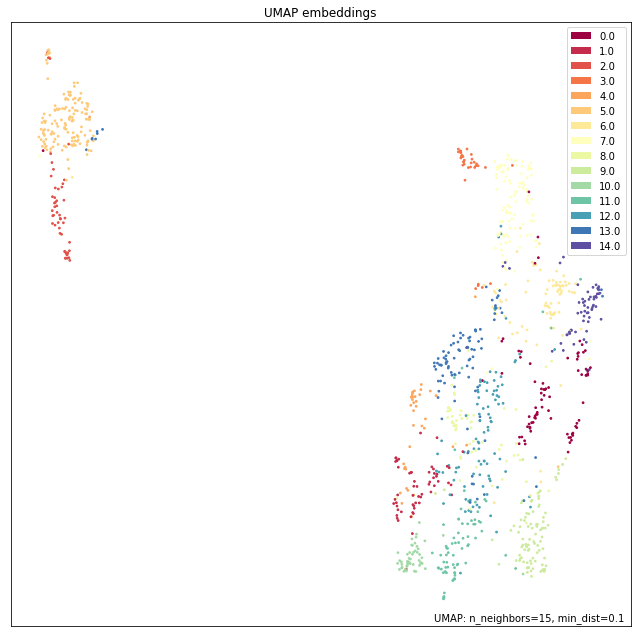

In [113]:
umap.plot.points(se_mapper, labels=conv_labels_30[::100])
plt.title('UMAP embeddings')
plt.show()

In [117]:
def plot_embeddings(embeddings, labels, train_intents, title='t-SNE embeddings', lw=0.01):
    x, y = embeddings.T
    wtrain_intents = train_intents
    
    markers = ['.', 'v', '^', '<', '>', "X", "s", "p", "P", "*", "d", "h"]

    plt.figure(figsize=(20, 15))

    for i, c in enumerate(np.unique(wtrain_intents)):
        plt.scatter(x[wtrain_intents == c],
                    y[wtrain_intents == c],
                    marker=markers[i],
                    alpha=0.8,
                    lw=lw,
                    c=np.array(labels)[wtrain_intents == c],
                    label=intent_encode[i] if i < len(intent_encode) else 'no intent')

    plt.legend()
    plt.title(title)

    plt.show()

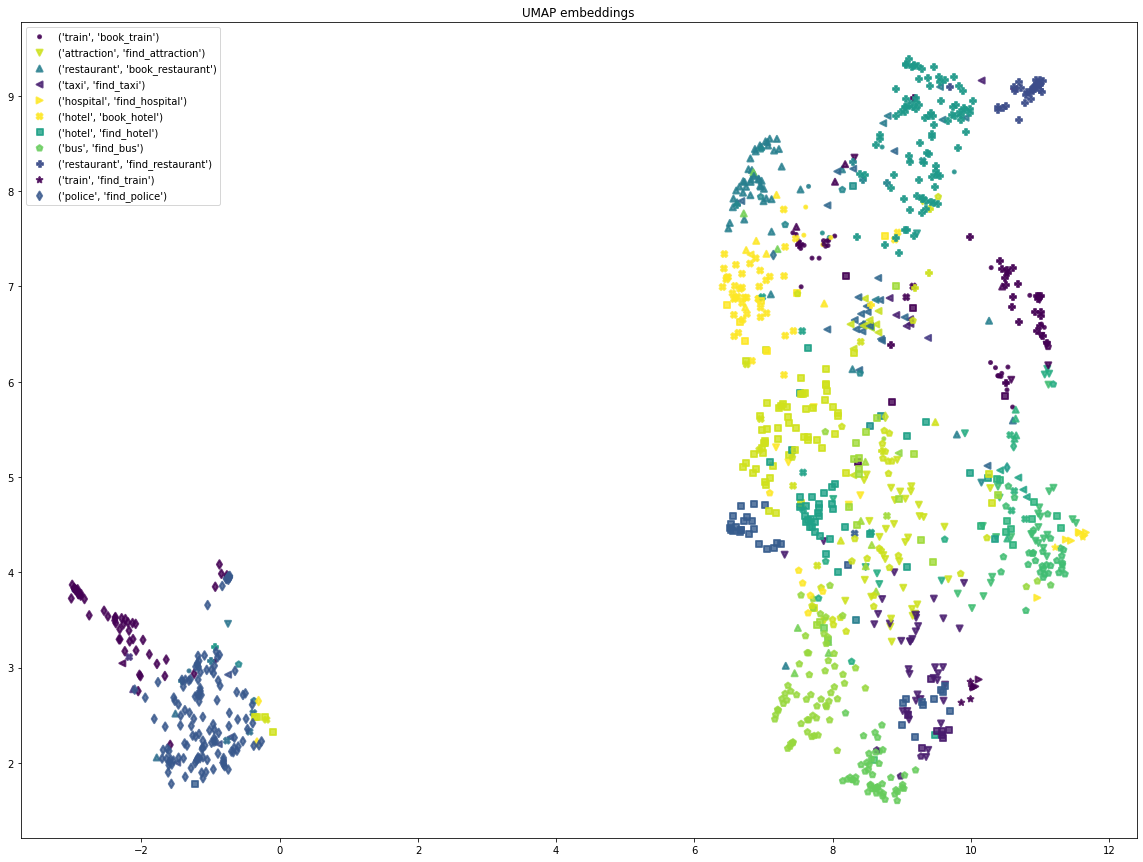

In [118]:
plot_embeddings(conv_mapper.embedding_, conv_labels_30[::100], train_intents[::100], title='UMAP embeddings', lw=2)

In [71]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

conv_pca = PCA(50).fit_transform(train_convert)
conv_tsne = TSNE().fit_transform(conv_pca[::10])

In [96]:
conv_tsne_100 = TSNE().fit_transform(conv_pca[::100])

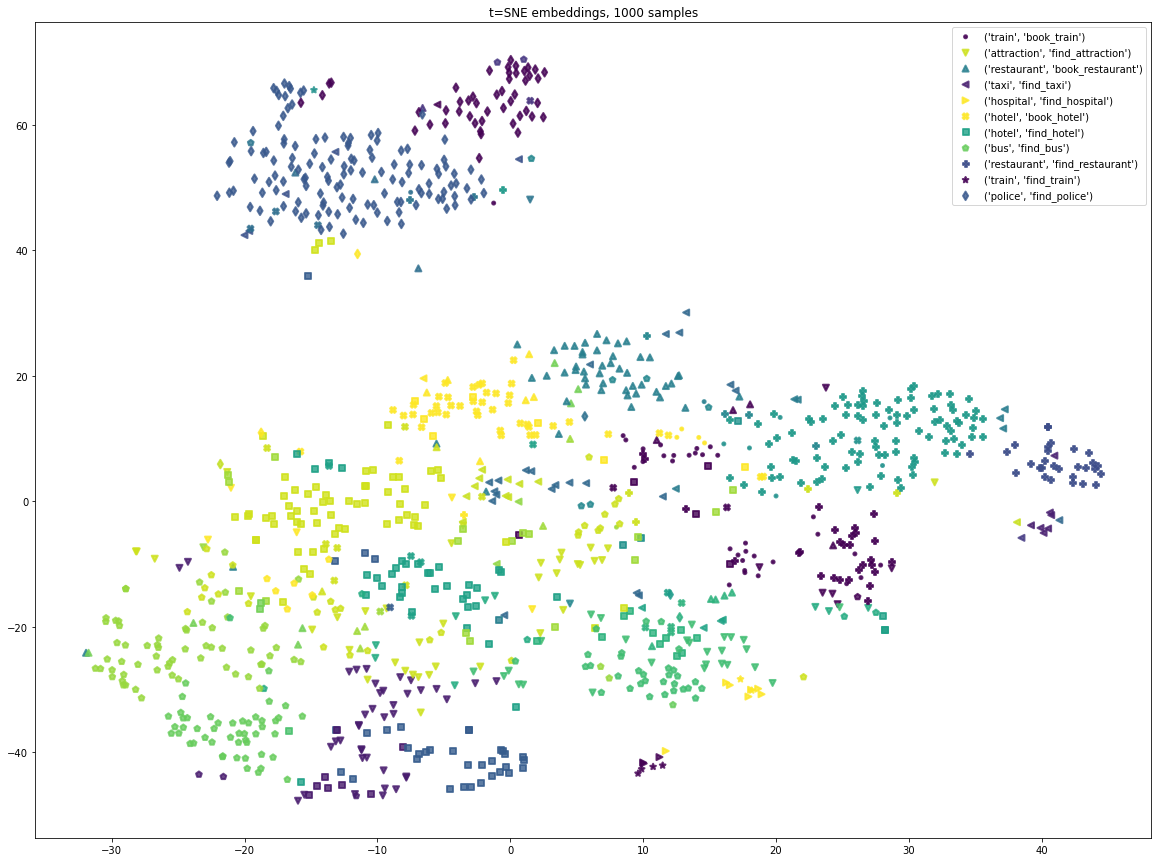

In [120]:
plot_embeddings(conv_tsne_100, conv_labels_30[::100], train_intents[::100], lw=2, title='t-SNE embeddings, 1000 samples')

In [92]:
clustering_conv_sep_pca = SubClustering(train, KMeansClustering, speaker_filter, {'n_clusters': 15}).fit(conv_pca)

In [93]:
conv_labels_30_pca = clustering_conv_sep_pca.get_labels()

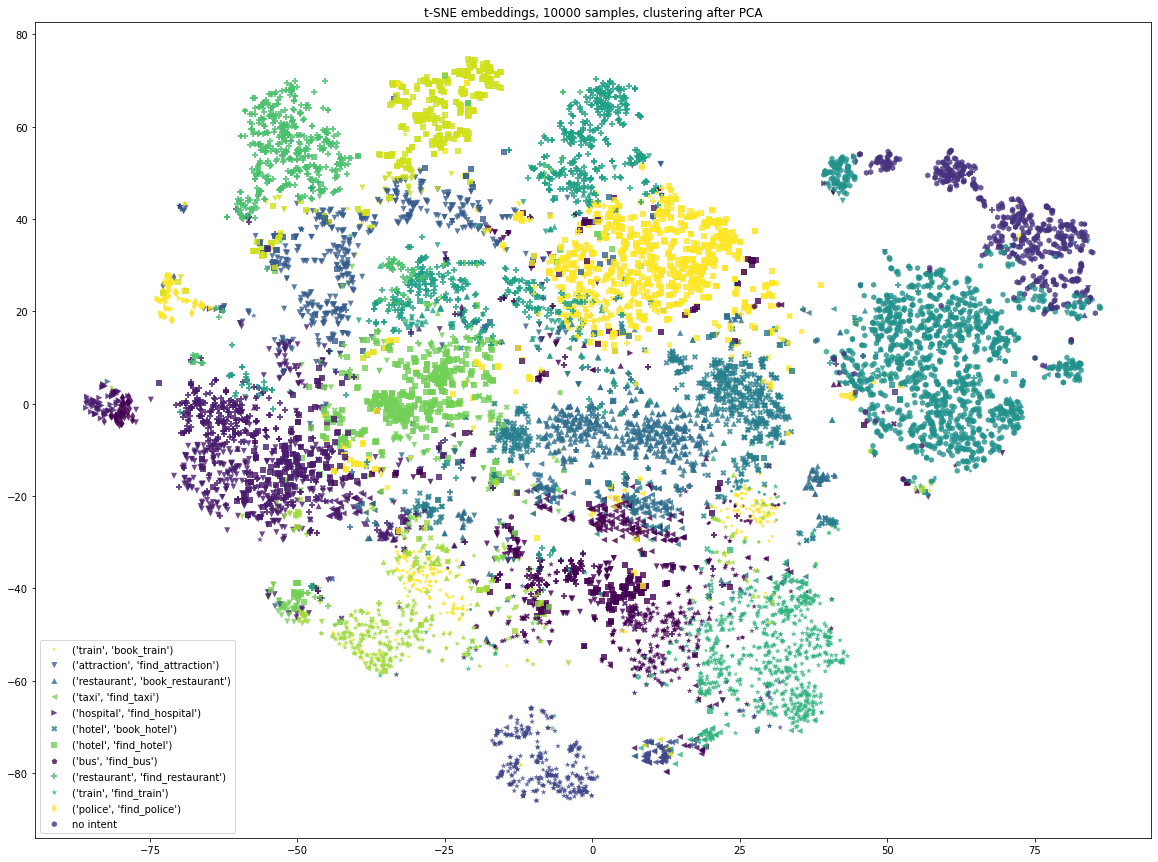

In [121]:
plot_embeddings(conv_tsne, conv_labels_30_pca[::10], train_intents[::10], title='t-SNE embeddings, 10000 samples, clustering after PCA')

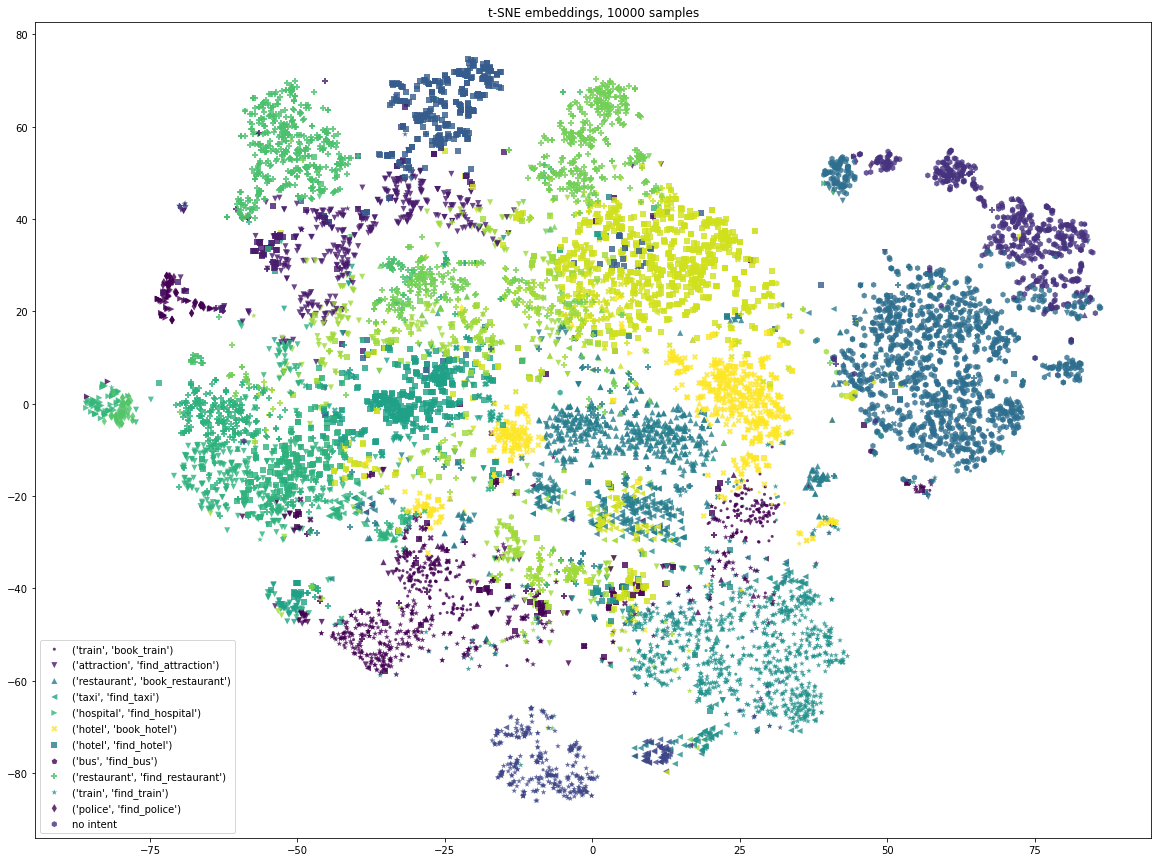

In [122]:
plot_embeddings(conv_tsne, conv_labels_30[::10], train_intents[::10], title='t-SNE embeddings, 10000 samples')

### Number of clusters

In [201]:
from tqdm.notebook import tqdm

#sizes = [2, 3, 5, 8, 10, 12, 15, 20, 25, 30, 35, 40, 50, 60, 75, 90, 100]
scores = []
#clusterings = []

for i, k in tqdm(enumerate(sizes), total=len(sizes)):
    #_clustering = SubClustering(train, 
    #                            KMeansClustering, 
    #                            speaker_filter, 
    #                            {'n_clusters': k}).fit(train_convert)
    #clusterings.append(_clustering)
    _clustering = clusterings[i]
    scores.append(score_clustering(_clustering, train_convert, each=10))

  0%|          | 0/17 [00:00<?, ?it/s]

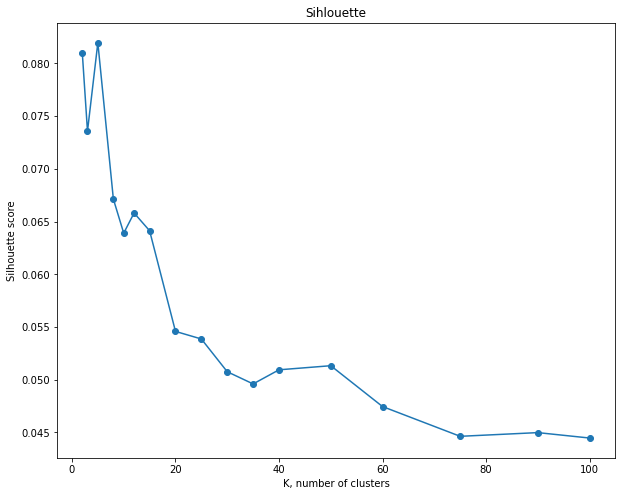

In [202]:
plt.figure(figsize=(10, 8))
plt.plot(sizes, [score[0] for score in scores], marker='o')

plt.title('Sihlouette')
plt.xlabel('K, number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [203]:
def clustering_intent_score(clustering, data):
    scores = []
    for cluster_idx in range(clustering.get_nclusters()):
        cluster = clustering.get_cluster(cluster_idx)
        cluster_intents = []
        for utt_idx in cluster:
            utt = data.get_utterance_by_idx(utt_idx)
            intents = get_active_intents(utt)
            if len(intents) == 0:
                intents = ['no_intent']
            cluster_intents.extend(['__'.join(intent) for intent in intents])
        
        intents, counts = np.unique(cluster_intents, return_counts=True)
        score = counts.max() / len(cluster)
        scores.append(score)
    scores = np.array(scores)
    return np.mean(scores[scores != 1.0]), scores

In [206]:
from tqdm.notebook import trange

intent_scores = []

for i in trange(len(sizes)):
    intent_scores.append(clustering_intent_score(clusterings[i], train)[0])

  0%|          | 0/17 [00:00<?, ?it/s]

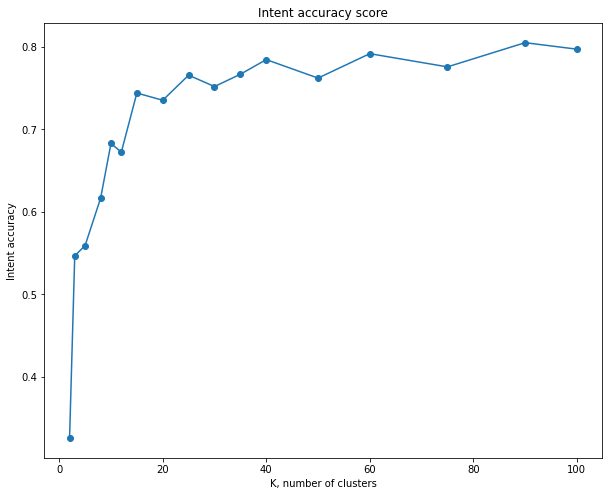

In [207]:
plt.figure(figsize=(10, 8))
plt.plot(sizes, intent_scores, marker='o')

plt.title('Intent accuracy score')
plt.xlabel('K, number of clusters')
plt.ylabel('Intent accuracy')
plt.show()

# Experiments (grig)

## Test Mark's code

In [1]:
from dialog_imports import *

  0%|          | 0/2 [00:00<?, ?it/s]

/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/test/dialogues_001.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/test/dialogues_002.json


  0%|          | 0/2 [00:00<?, ?it/s]

/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/dev/dialogues_001.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/dev/dialogues_002.json


  0%|          | 0/17 [00:00<?, ?it/s]

/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_001.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_011.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_007.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_010.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_017.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_005.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_015.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_012.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_016.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_013.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_004.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialogues_009.json
/home/admin/research/data/multiwoz/data/MultiWOZ_2.2/train/dialo

In [2]:
cluster_counts = [5, 10, 15, 20, 25, 30, 40, 50, 60, 75, 90, 100, 125, 150, 175, 200, 250, 300]
cluster_counts_small = [5, 10, 25, 50]

In [280]:
class AccuracyAnalyzer:
    def __init__(self, name, embedder, embedding, rates=[1,3,5,10], algo=KMeansClustering):
        self.rates = rates
        self.ks = []
        self.clusterings = {}
        self.graph_logs = {}
        self.name = name
        self.embeddings = embedding;
        self.embedder = embedder
        self.algo = algo
    
    def build(self, ks):
        self.ks = list(set(ks + self.ks))
        self.ks.sort()
        for k in tqdm(self.ks):
            if k not in self.clusterings:
                self.clustering = self.algo(n_clusters=k).fit(self.embeddings)
                self.clustering.clustering.labels_ = self.clustering.clustering.predict(self.embedder.embeddings)
                self.clusterings[k] = self.clustering
            else:
                self.clustering = self.clusterings[k]

            if k not in self.graph_logs:
                graph = FrequencyDialogueGraph(train, self.embedder, self.clustering)
                graph._build()
                score = graph.success_rate(test, self.rates)
                self.graph_logs[k] = (graph, score)
                print(k, score)
            else:
                print(f'skipping {k}')
        
    def plot(self):
        plt.figure(figsize=(16,8))
        for index, rate in enumerate(self.rates):
            plt.plot(self.ks, [self.graph_logs[k][1][1][index] for k in self.ks], label=f'Acc@{rate}')
        plt.legend()
        plt.title(self.name)
        plt.xlabel('Number of clusters')
        plt.ylabel('Accuaracy')
        plt.show()

In [4]:
def accuracy_multiplot(analyzers: list[AccuracyAnalyzer], rate):
    plt.figure(figsize=(16,8))
    for analyzer in analyzers:
        index = analyzer.rates.index(rate)
        plt.plot(analyzer.ks, [analyzer.graph_logs[k][1][1][index] for k in analyzer.ks], label=analyzer.name)
    plt.legend()
    plt.title(f'Acc@{rate}')
    plt.xlabel('Number of clusters')
    plt.ylabel(f'Acc@{rate}')
    plt.show()
        

In [18]:
sentence_embedder = SentenceEmbedder(device=0)
sentence_embedding = sentence_embedder.encode_dataset(train)

In [66]:
anal1 = AccuracyAnalyzer("Sentence Embedder, KMeans, FrequencyDialogGraph", sentence_embedder, sentence_embedding)

In [68]:
anal1.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (4.267781468783749, array([0.88932166, 1.        , 1.        ]))
10 (4.214336443638728, array([0.74920815, 0.88129116, 1.        ]))
15 (3.8667705029866117, array([0.65424636, 0.79413821, 0.95130929]))
20 (3.6319491565156254, array([0.59504121, 0.73573086, 0.9102694 ]))
25 (3.3561998552388483, array([0.53947894, 0.68234767, 0.8698407 ]))
30 (3.2349439717802655, array([0.51409653, 0.65184074, 0.83442466]))
40 (3.0179819193142734, array([0.46893516, 0.60908417, 0.79080363]))
50 (2.7919996954685176, array([0.42185632, 0.57283486, 0.76677614]))
60 (2.6567426918560932, array([0.39301463, 0.53084641, 0.73595947]))
75 (2.4580360511642447, array([0.35938178, 0.49600967, 0.68665325]))
90 (2.3340867413569084, array([0.35258556, 0.47675346, 0.65524534]))
100 (2.2648601969527014, array([0.34055857, 0.45838652, 0.64659529]))
125 (2.0875010904022733, array([0.31755741, 0.4215864 , 0.59732654]))
150 (1.941713199867514, array([0.2885997 , 0.39297744, 0.55916479]))
175 (1.8845684351238925, array([0.2

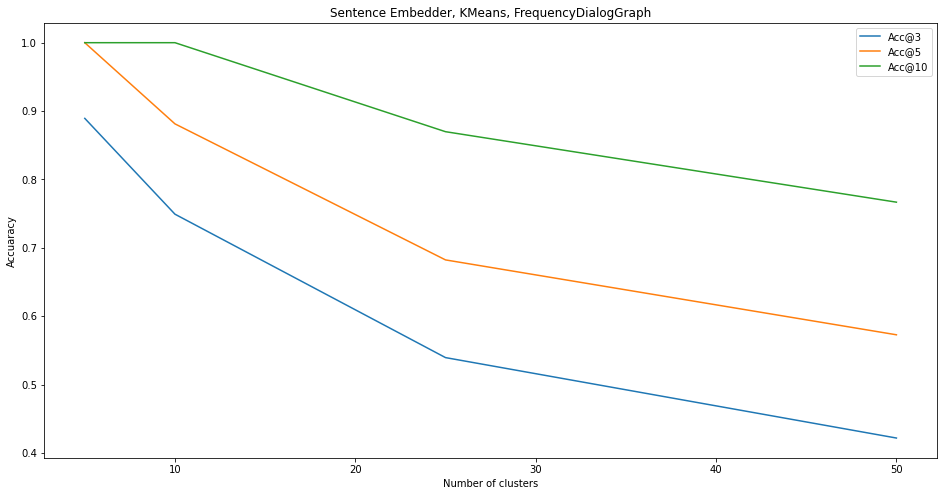

In [22]:
anal1.plot()

## ConveRT

In [26]:
anal = AccuracyAnalyzer("KMeans, ConveRT, FDD", cached_convert_response, resp_train_convert)
anal.build(cluster_counts_small)

  0%|          | 0/4 [00:00<?, ?it/s]

5 (4.290835611531661, array([0.92019686, 1.        , 1.        ]))
10 (4.396750826764197, array([0.77813421, 0.90710719, 1.        ]))
25 (3.484379764196585, array([0.59899623, 0.72729356, 0.88693731]))
50 (3.09275466785254, array([0.50222025, 0.63342735, 0.80840899]))


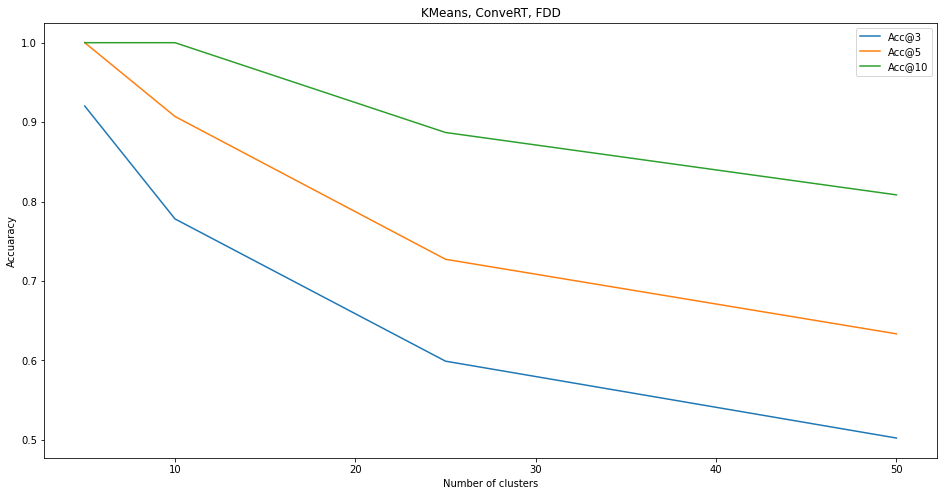

In [27]:
anal.plot()

## Comparision

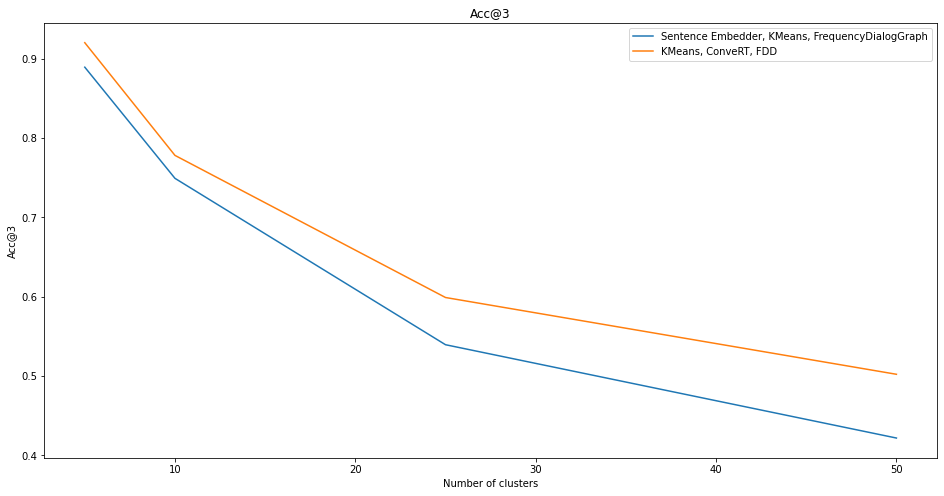

In [28]:
accuracy_multiplot([anal1, anal], 3)

## Functional ConveRT

### Interface (IConveRTEmbeddingsProcessor)

In [21]:
class IConveRTEmbeddingsProcessor:
    def __init__(self):
        pass
    
    def process_utterances(self, response_embedding: np.array, context_embedding: np.array) -> np.array:
        pass


### Implementations(IConveRTEmbeddingsProcessor)

In [30]:
class ResponseConveRTEmbeddingsProcessor(IConveRTEmbeddingsProcessor):
    def process_utterances(self, response_embedding: np.array, context_embedding: np.array) -> np.array:
        return response_embedding

In [36]:
class ContextConveRTEmbeddingsProcessor(IConveRTEmbeddingsProcessor):
    def process_utterances(self, response_embedding: np.array, context_embedding: np.array) -> np.array:
        return context_embedding

In [32]:
class ConcatenatedConveRTEmbeddingsProcessor(IConveRTEmbeddingsProcessor):
    def process_utterances(self, response_embedding: np.array, context_embedding: np.array) -> np.array:
        return np.concatenate([response_embedding, context_embedding], axis=1)

In [30]:
class NormalizedConveRTContextsProcessor(IConveRTEmbeddingsProcessor):
    def process_utterances(self, response_embedding: np.array, context_embedding: np.array) -> np.array:
        X = context_embedding
        length = np.sqrt((X**2).sum(axis=1))[:,None]
        return X / length

In [33]:
class ConcatenatedWithFunctionConveRTEmbeddingsProcessor(IConveRTEmbeddingsProcessor):
    def __init__(self, function):
        self.function = function
        
    def process_utterances(self, response_embedding: np.array, context_embedding: np.array) -> np.array:
        return np.concatenate([response_embedding, context_embedding, self.function(response_embedding, context_embedding)], axis=1)

In [52]:
class ConcatenatedWithFunctionConveRTEmbeddingsProcessor2(IConveRTEmbeddingsProcessor):
    def __init__(self, function):
        self.function = function
        
    def process_utterances(self, response_embedding: np.array, context_embedding: np.array) -> np.array:
        return np.concatenate([context_embedding, self.function(response_embedding, context_embedding)], axis=1)

### Embedding

In [24]:
class FunctionalCoveRTEmbedding:
    def __init__(self, cached_contexts: CachedEmbeddings, cached_responses: CachedEmbeddings, processor: IConveRTEmbeddingsProcessor):
        self.cached_responses = cached_responses
        self.cached_contexts = cached_contexts
        self.process = processor.process_utterances
    
    def encode_dialogue(self, dialogue: Dialogue) -> np.array:
        return self.process(self.cached_responses.encode_dialogue(dialogue), self.cached_contexts.encode_dialogue(dialogue))

    def encode_new_dialogue(self, dialogue: Dialogue) -> np.array:
        return self.process(self.cached_responses.encode_new_dialogue(dialogue), self.cached_contexts.encode_new_dialogue(dialogue))
    
    def encode_utterances(self, utts):
        return self.process(self.cached_responses.encode_utterances(utts), self.cached_contexts.encode_utterances(utts))
    
    

### Cached

In [28]:
test_convert = np.load("test_convert_context.np.npy")
resp_test_convert = np.load("test_convert_responses.np.npy")

train_convert = np.load("train_convert_context.np.npy")
resp_train_convert = np.load("train_convert_responses.np.npy")

cached_convert_context = CachedEmbeddings(train, train_convert, test, test_convert)
cached_convert_response = CachedEmbeddings(train, resp_train_convert, test, resp_test_convert)

### Experiments

In [69]:
processor = ResponseConveRTEmbeddingsProcessor()
anal2 = AccuracyAnalyzer("ConveRT Response, KMeans, FrequencyDialogGraph", FunctionalCoveRTEmbedding(cached_convert_context, cached_convert_response, processor), processor.process_utterances(resp_train_convert, train_convert))

In [70]:
anal2.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (4.290835611531661, array([0.92019686, 1.        , 1.        ]))
10 (4.396750826764197, array([0.77813421, 0.90710719, 1.        ]))
15 (3.933566850781761, array([0.67793991, 0.81892577, 0.95827352]))
20 (3.6404565801341398, array([0.62025189, 0.75300078, 0.91522504]))
25 (3.484379764196585, array([0.59899623, 0.72729356, 0.88693731]))
30 (3.379004794969701, array([0.56334933, 0.70275695, 0.87893037]))
40 (3.271599603981967, array([0.53705202, 0.67463208, 0.83116252]))
50 (3.09275466785254, array([0.50222025, 0.63342735, 0.80840899]))
60 (2.9465912748880405, array([0.4751611 , 0.60485618, 0.78317229]))
75 (2.7053924847961954, array([0.42984733, 0.55898607, 0.74190388]))
90 (2.5552469130613367, array([0.39995363, 0.53077042, 0.708244  ]))
100 (2.493728460841022, array([0.37540989, 0.51585353, 0.70668159]))
125 (2.338520479836839, array([0.35987487, 0.48753387, 0.66119124]))
150 (2.1487933275936144, array([0.32729076, 0.44943875, 0.61734922]))
175 (1.982769092929248, array([0.29494387,

In [71]:
processor = ContextConveRTEmbeddingsProcessor()
anal3 = AccuracyAnalyzer("ConveRT Contexts, KMeans, FrequencyDialogGraph", FunctionalCoveRTEmbedding(cached_convert_context, cached_convert_response, processor), processor.process_utterances(resp_train_convert, train_convert))

In [72]:
anal3.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (3.726898988837948, array([0.9371173, 1.       , 1.       ]))
10 (4.103061147528825, array([0.82883295, 0.92979485, 1.        ]))
15 (4.21707414609265, array([0.77776946, 0.89189008, 0.98559882]))
20 (4.063403182787195, array([0.76423958, 0.88112851, 0.97127093]))
25 (4.037748876506039, array([0.7536662 , 0.86021855, 0.96024911]))
30 (3.935993593014438, array([0.71083141, 0.83401078, 0.94979332]))
40 (3.86545911920928, array([0.67704584, 0.81882473, 0.93575936]))
50 (3.7059738616621316, array([0.64492678, 0.79072302, 0.90699732]))
60 (3.59510011990211, array([0.6178239 , 0.75843016, 0.89059005]))
75 (3.472408238766755, array([0.57709017, 0.71704727, 0.8731743 ]))
90 (3.3409899953457955, array([0.55116021, 0.69796011, 0.86287099]))
100 (3.2350430240513997, array([0.52272776, 0.66685667, 0.84137997]))
125 (3.0841179434703565, array([0.49816138, 0.63745216, 0.80385596]))
150 (2.911550863402944, array([0.46831219, 0.60102212, 0.77220693]))
175 (2.863491964050532, array([0.46059668, 0.591

In [73]:
processor = ConcatenatedConveRTEmbeddingsProcessor()
anal4 = AccuracyAnalyzer("ConveRT Contexts+Responses, KMeans, FrequencyDialogGraph", FunctionalCoveRTEmbedding(cached_convert_context, cached_convert_response, processor), processor.process_utterances(resp_train_convert, train_convert))

In [74]:
anal4.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (3.9780824237067747, array([0.91287835, 1.        , 1.        ]))
10 (4.1032272819377615, array([0.83665064, 0.92665604, 1.        ]))
15 (4.066690421014383, array([0.76599294, 0.87911782, 0.97591032]))
20 (3.894867843828994, array([0.73905712, 0.85091619, 0.9552214 ]))
25 (3.830750332465608, array([0.70952691, 0.81507907, 0.93992337]))
30 (3.820277426766553, array([0.67392324, 0.82123546, 0.93639652]))
40 (3.737427383134446, array([0.6516106 , 0.78234388, 0.90422552]))
50 (3.536375872030357, array([0.59275402, 0.74191696, 0.89091508]))
60 (3.3865057108460905, array([0.56007295, 0.70101541, 0.86201919]))
75 (3.2740868150299214, array([0.52941611, 0.68306899, 0.84961069]))
90 (3.091932386957713, array([0.50399733, 0.64469348, 0.8219147 ]))
100 (3.012387059602861, array([0.48074141, 0.63518112, 0.80562042]))
125 (2.793309738583942, array([0.43552495, 0.57887859, 0.75971592]))
150 (2.6009719806118556, array([0.40363833, 0.53371349, 0.71462389]))
175 (2.501393055442278, array([0.38367728

In [75]:
processor = ConcatenatedWithFunctionConveRTEmbeddingsProcessor(lambda x, y: np.abs(x-y))
anal7 = AccuracyAnalyzer("ConveRT Contexts+Responses+|ctx-response|, KMeans, FrequencyDialogGraph", FunctionalCoveRTEmbedding(cached_convert_context, cached_convert_response, processor), processor.process_utterances(resp_train_convert, train_convert))

In [76]:
anal7.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (3.9650435743825057, array([0.91050301, 1.        , 1.        ]))
10 (4.226101365259381, array([0.83858542, 0.94160234, 1.        ]))
15 (4.124152800483963, array([0.76321067, 0.87833618, 0.98093339]))
20 (3.959542743678419, array([0.71867126, 0.83924773, 0.95311572]))
25 (3.9216380546305296, array([0.70740155, 0.83584974, 0.95298535]))
30 (3.830481375876886, array([0.68800856, 0.81911229, 0.93297273]))
40 (3.6643393925558057, array([0.63324957, 0.78034991, 0.90529655]))
50 (3.4919834187003778, array([0.58287302, 0.7259528 , 0.8830432 ]))
60 (3.486586498158567, array([0.58161566, 0.72295048, 0.87366693]))
75 (3.2913026069391025, array([0.53505498, 0.68606124, 0.84863733]))
90 (3.1652447643309394, array([0.5068911 , 0.64963597, 0.82205555]))
100 (2.953688513651798, array([0.47216708, 0.61350258, 0.78945752]))
125 (2.752707935328246, array([0.42236661, 0.57092028, 0.76517238]))
150 (2.646344265515076, array([0.41019405, 0.54855745, 0.73461895]))
175 (2.4607033525308983, array([0.369663

In [77]:
processor = ConcatenatedWithFunctionConveRTEmbeddingsProcessor2(lambda x, y: np.abs(x-y))
anal8 = AccuracyAnalyzer("ConveRT Contexts+|ctx-response|, KMeans, FrequencyDialogGraph", FunctionalCoveRTEmbedding(cached_convert_context, cached_convert_response, processor), processor.process_utterances(resp_train_convert, train_convert))

In [78]:
anal8.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (4.224458152398951, array([0.92015482, 1.        , 1.        ]))
10 (4.194080028917506, array([0.84703205, 0.95815531, 1.        ]))
15 (4.270634192022448, array([0.77241108, 0.89849662, 0.98827936]))
20 (4.095903997064371, array([0.74803236, 0.86933562, 0.97744025]))
25 (4.061808507947582, array([0.73255582, 0.86081741, 0.96350337]))
30 (3.9380909106572277, array([0.71228365, 0.83343171, 0.94101495]))
40 (3.7527637430422396, array([0.64319812, 0.79079454, 0.92361651]))
50 (3.650687950278968, array([0.60519668, 0.75801846, 0.89908012]))
60 (3.5193982381033537, array([0.58019223, 0.73238426, 0.88161232]))
75 (3.335507034911758, array([0.54230616, 0.6929345 , 0.85355902]))
90 (3.236636044218654, array([0.52437113, 0.65179317, 0.8312082 ]))
100 (3.1603841798600953, array([0.50808803, 0.6398346 , 0.81700878]))
125 (2.9874475873053594, array([0.47619384, 0.61597437, 0.79548211]))
150 (2.7922082046355343, array([0.43297411, 0.57051522, 0.74434418]))
175 (2.665916261102639, array([0.4074542

In [80]:
analyzer_list = [anal1, anal2, anal3, anal4, anal7, anal8]

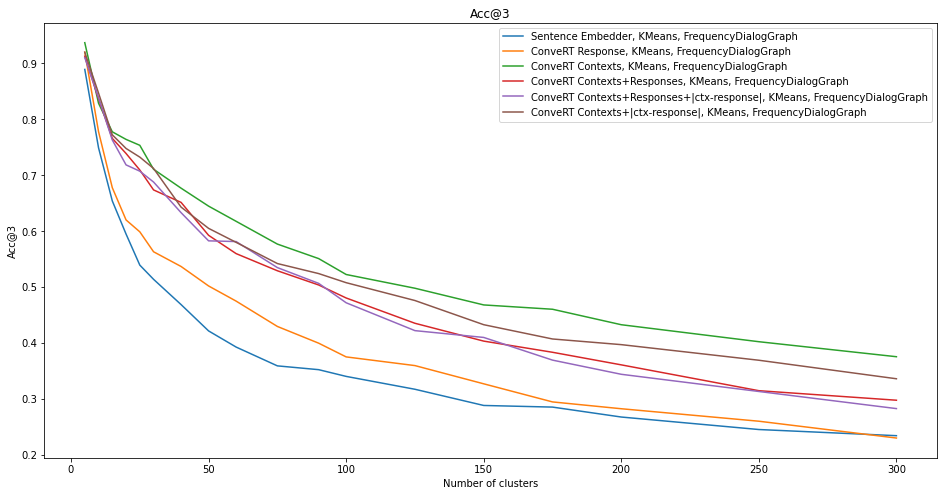

In [81]:
accuracy_multiplot(analyzer_list, 3)

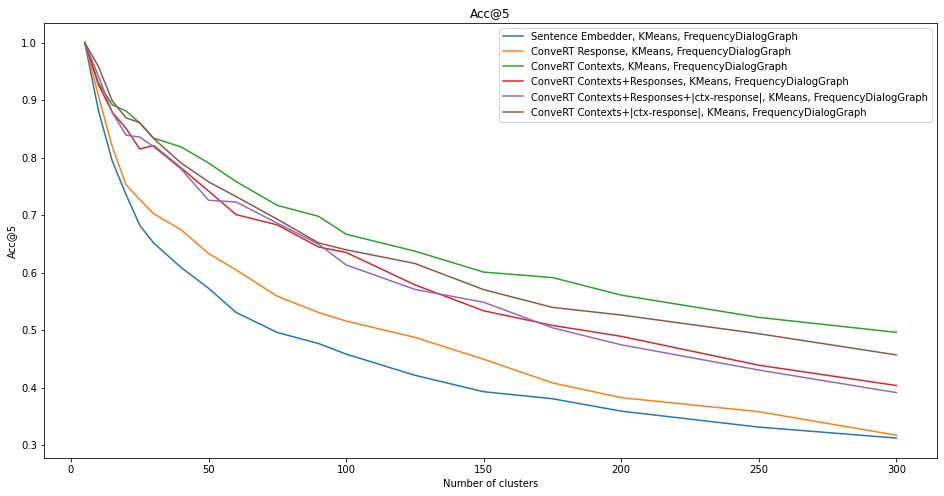

In [82]:
accuracy_multiplot(analyzer_list, 5)

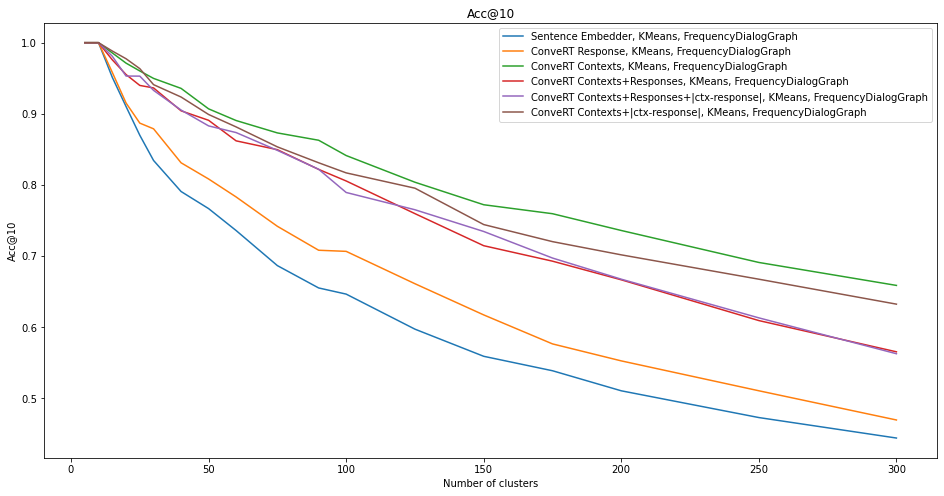

In [83]:
accuracy_multiplot(analyzer_list, 10)

In [44]:
processor = NormalizedConveRTContextsProcessor()
anal9s = AccuracyAnalyzer("ConveRT, KMeans~normalized, FrequencyDialogGraph", FunctionalCoveRTEmbedding(cached_convert_context, cached_convert_response, processor), processor.process_utterances(resp_train_convert, train_convert))

In [45]:
anal9s.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (3.726898988837948, array([0.9371173, 1.       , 1.       ]))
10 (4.103061147528825, array([0.82883295, 0.92979485, 1.        ]))
15 (4.21707414609265, array([0.77776946, 0.89189008, 0.98559882]))
20 (4.063346421017029, array([0.76423958, 0.88112851, 0.97127093]))
25 (4.036814635713722, array([0.75348009, 0.85866084, 0.9599382 ]))
30 (3.935993593014438, array([0.71083141, 0.83401078, 0.94979332]))
40 (3.826064103338301, array([0.66982966, 0.81175143, 0.92595664]))
50 (3.7059738616621316, array([0.64492678, 0.79072302, 0.90699732]))
60 (3.6399621897242858, array([0.60814548, 0.76780874, 0.90209667]))
75 (3.5259186361845543, array([0.5944772 , 0.73889403, 0.88103421]))
90 (3.3484174848648536, array([0.55717589, 0.69311337, 0.86196147]))
100 (3.2350430240513997, array([0.52272776, 0.66685667, 0.84137997]))
125 (3.0841179434703565, array([0.49816138, 0.63745216, 0.80385596]))
150 (2.9570342060313055, array([0.47661209, 0.60570341, 0.77571347]))
175 (2.820305540821833, array([0.45310493, 

In [46]:
processor = ContextConveRTEmbeddingsProcessor()
anal3s = AccuracyAnalyzer("ConveRT Contexts, KMeans, FrequencyDialogGraph", FunctionalCoveRTEmbedding(cached_convert_context, cached_convert_response, processor), processor.process_utterances(resp_train_convert, train_convert))

In [47]:
anal3s.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (3.726898988837948, array([0.9371173, 1.       , 1.       ]))
10 (4.103061147528825, array([0.82883295, 0.92979485, 1.        ]))
15 (4.21707414609265, array([0.77776946, 0.89189008, 0.98559882]))
20 (4.063403182787195, array([0.76423958, 0.88112851, 0.97127093]))
25 (4.036868620791753, array([0.7535412 , 0.85868227, 0.96024911]))
30 (3.935993593014438, array([0.71083141, 0.83401078, 0.94979332]))
40 (3.86545911920928, array([0.67704584, 0.81882473, 0.93575936]))
50 (3.7059738616621316, array([0.64492678, 0.79072302, 0.90699732]))
60 (3.59510011990211, array([0.6178239 , 0.75843016, 0.89059005]))
75 (3.471314759776819, array([0.57682569, 0.71599985, 0.87283699]))
90 (3.3409899953457955, array([0.55116021, 0.69796011, 0.86287099]))
100 (3.2350430240513997, array([0.52272776, 0.66685667, 0.84137997]))
125 (3.0879009715466994, array([0.50039195, 0.6388094 , 0.80499934]))
150 (2.911550863402944, array([0.46831219, 0.60102212, 0.77220693]))
175 (2.862883013782407, array([0.46069942, 0.591

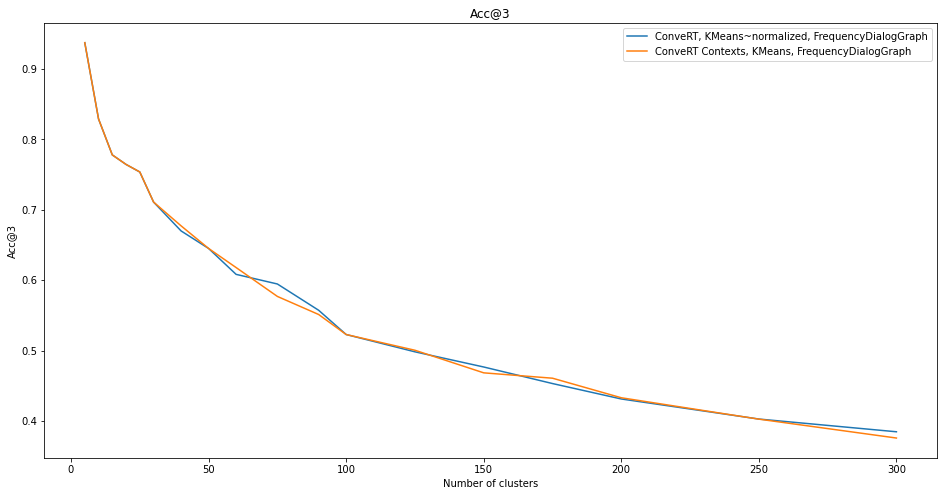

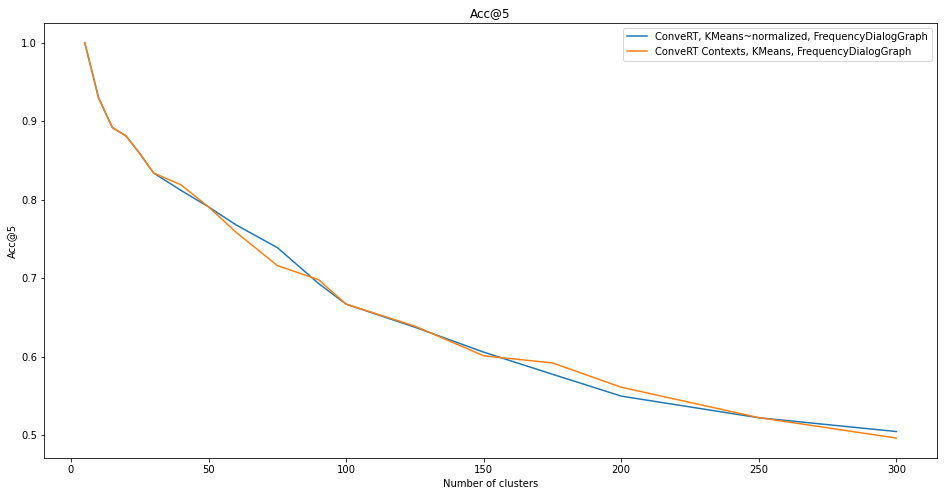

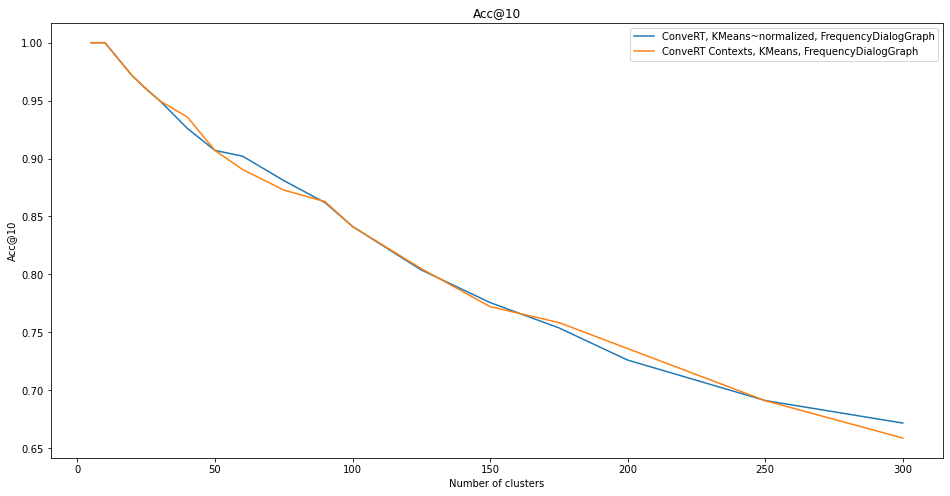

In [48]:
analyzer_list_small = [anal9s, anal3s]
accuracy_multiplot(analyzer_list_small, 3)
accuracy_multiplot(analyzer_list_small, 5)
accuracy_multiplot(analyzer_list_small, 10)

In [63]:
processor =  ContextConveRTEmbeddingsProcessor()
anal3sb = AccuracyAnalyzer("ConveRT Contexts, KMeans, FrequencyDialogGraph", FunctionalCoveRTEmbedding(cached_convert_context, cached_convert_response, processor),processor.process_utterances(resp_train_convert, train_convert), algo=MiniBatchKMeansClustering)

In [64]:
anal3sb.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (4.130727810374828, array([0.92864209, 1.        , 1.        ]))
10 (3.94510797817567, array([0.78221798, 0.91702162, 1.        ]))
15 (4.1782340988807345, array([0.79125866, 0.90582383, 0.98482174]))
20 (4.194436618243271, array([0.7476943 , 0.87150767, 0.96741801]))
25 (3.9688876180339183, array([0.68720141, 0.8305093 , 0.95445165]))
30 (3.9301740681403885, array([0.72014363, 0.82815444, 0.94354512]))
40 (3.6681579453159707, array([0.64115564, 0.78138573, 0.92321432]))
50 (3.5805064175365997, array([0.61735575, 0.76712314, 0.89737213]))
60 (3.5025921808896006, array([0.57918093, 0.73556265, 0.88938955]))
75 (3.3926846728529054, array([0.56531459, 0.71117473, 0.86565306]))
90 (3.3014701155290793, array([0.53899333, 0.67898652, 0.85054903]))
100 (3.1966777901069623, array([0.5296881 , 0.66089103, 0.82435273]))
125 (3.001972491657565, array([0.49050996, 0.62330338, 0.79028869]))
150 (2.860468920365467, array([0.45591128, 0.60120523, 0.7728888 ]))
175 (2.7663904282319103, array([0.4411

In [67]:
anal3sb.name = "ConveRT Contexts, MiniBatchKMeans, FrequencyDialogGraph"

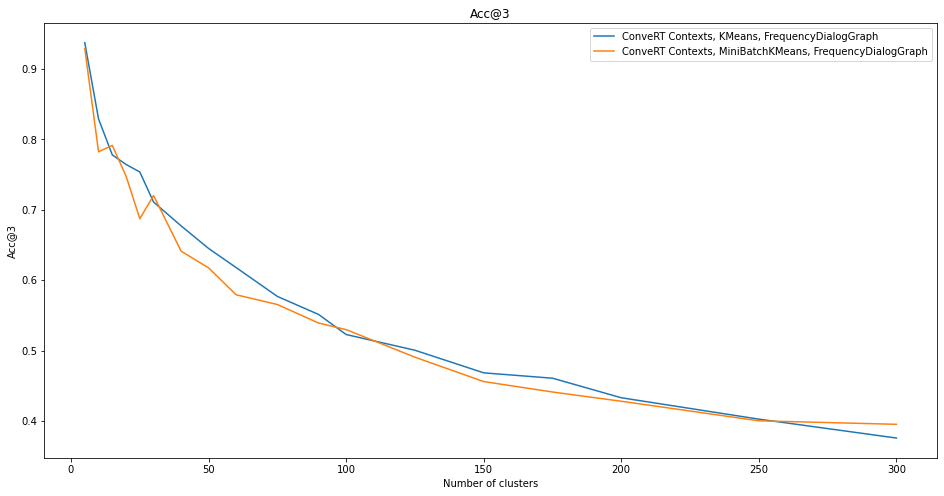

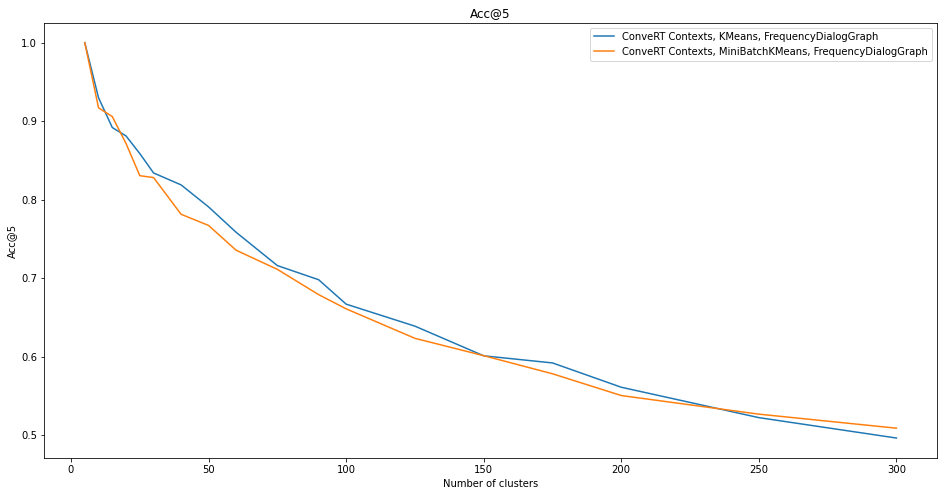

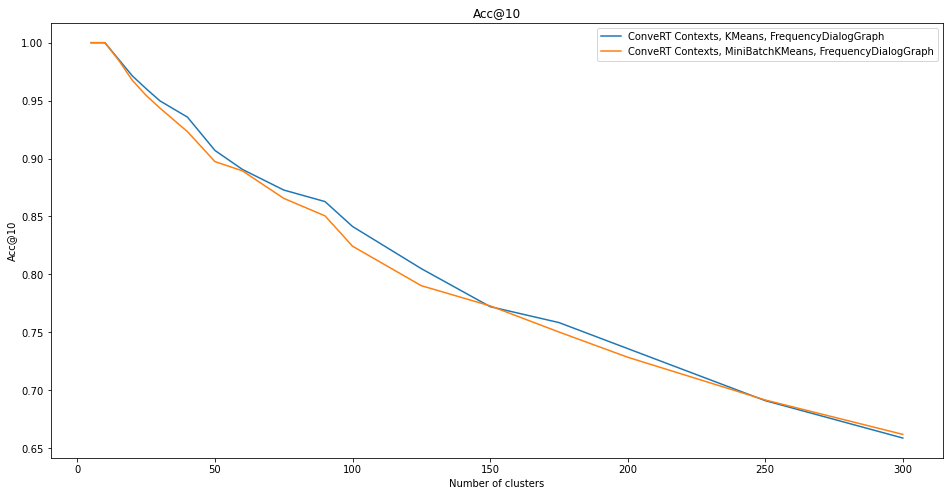

In [68]:
analyzer_list_small = [anal3s, anal3sb]
accuracy_multiplot(analyzer_list_small, 3)
accuracy_multiplot(analyzer_list_small, 5)
accuracy_multiplot(analyzer_list_small, 10)

# Dense

## Pretrain

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

In [21]:
device = 'cuda'

In [22]:
def create_dense(size=512, device=0):
    return nn.Sequential(nn.Linear(size,size),nn.ReLU(size),nn.Linear(size,size)).to(device)

def pretrain_model(model, optimizer, lossfunction, X, Y, losses=None, n_epochs=100, batch_size=128):
    for epoch in tqdm(range(n_epochs)):
        permutation = torch.randperm(X.size()[0])
        epoch_loss = 0
        for i in range(0,X.size()[0], batch_size):
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], Y[indices]

            # in case you wanted a semi-full example
            outputs = model.forward(batch_x)
            loss = lossfunction(outputs,batch_y)
            epoch_loss += loss.cpu().item()

            loss.backward()
            optimizer.step()
        if losses is not None:
            losses.append(epoch_loss)

In [45]:
def plot_loss(losses):
    plt.figure(figsize=(16,8))
    plt.plot(range(len(losses)), losses)
    plt.title("Loss from epoch")
    plt.show()

In [24]:
torch_context_train = torch.tensor(train_convert).to(device)
torch_context_test = torch.tensor(test_convert).to(device)

In [25]:
model = create_dense()
losses = []

In [67]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
lossfunction = lambda y_pred, y_target: ((y_pred-y_target)**2).sum()
train(model, optimizer, lossfunction, torch_context_train, torch_context_train, losses = losses)

  0%|          | 0/100 [00:00<?, ?it/s]

In [69]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
lossfunction = lambda y_pred, y_target: ((y_pred-y_target)**2).sum()
train(model, optimizer, lossfunction, torch_context_train, torch_context_train, losses = losses)

  0%|          | 0/100 [00:00<?, ?it/s]

In [81]:
optimizer = optim.Adam(model.parameters(), lr=0.00000001)
lossfunction = lambda y_pred, y_target: ((y_pred-y_target)**2).sum()
train(model, optimizer, lossfunction, torch_context_train, torch_context_train, losses = losses, n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

## Creating model base embedding

In [27]:
densed_train = model(torch_context_train).cpu().detach().numpy()
densed_test = model(torch_context_test).cpu().detach().numpy()
densed_embedding = CachedEmbeddings(train, densed_train, test, densed_test)

## Evaluation of pretrain

In [30]:
anal_baseline = AccuracyAnalyzer("MiniBatchKMeans, ConveRT, FDD", cached_convert_context, train_convert, algo=MiniBatchKMeansClustering)
anal_baseline.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (4.130727810374828, array([0.92864209, 1.        , 1.        ]))
10 (3.94510797817567, array([0.78221798, 0.91702162, 1.        ]))
15 (4.1782340988807345, array([0.79125866, 0.90582383, 0.98482174]))
20 (4.194436618243271, array([0.7476943 , 0.87150767, 0.96741801]))
25 (3.9688876180339183, array([0.68720141, 0.8305093 , 0.95445165]))
30 (3.9301740681403885, array([0.72014363, 0.82815444, 0.94354512]))
40 (3.6681579453159707, array([0.64115564, 0.78138573, 0.92321432]))
50 (3.5805064175365997, array([0.61735575, 0.76712314, 0.89737213]))
60 (3.5025921808896006, array([0.57918093, 0.73556265, 0.88938955]))
75 (3.3926846728529054, array([0.56531459, 0.71117473, 0.86565306]))
90 (3.3014701155290793, array([0.53899333, 0.67898652, 0.85054903]))
100 (3.1966777901069623, array([0.5296881 , 0.66089103, 0.82435273]))
125 (3.001972491657565, array([0.49050996, 0.62330338, 0.79028869]))
150 (2.860468920365467, array([0.45591128, 0.60120523, 0.7728888 ]))
175 (2.7663904282319103, array([0.4411

In [33]:
anal_pretrained = AccuracyAnalyzer("MiniBatchKMeans, Dense^2(ConveRT contexts) pretrained, FDD", densed_embedding, densed_train, algo=MiniBatchKMeansClustering)
anal_pretrained.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (4.366426520722212, array([0.92503437, 1.        , 1.        ]))
10 (4.230930614277966, array([0.80607525, 0.92537839, 1.        ]))
15 (4.021986722216251, array([0.78031607, 0.89694925, 0.98630382]))
20 (4.046606450351678, array([0.71359241, 0.86290461, 0.9640192 ]))
25 (4.111468343957007, array([0.73338752, 0.86315379, 0.96347847]))
30 (3.9150341677872516, array([0.68460935, 0.82520813, 0.9367838 ]))
40 (3.841138527965064, array([0.65960715, 0.80396135, 0.92188681]))
50 (3.6668845959873613, array([0.62698887, 0.76437072, 0.90166999]))
60 (3.52205561831367, array([0.60939717, 0.74942054, 0.88363638]))
75 (3.3978539337561675, array([0.55922663, 0.71795936, 0.87439929]))
90 (3.2617340339044816, array([0.54419071, 0.68268831, 0.8426087 ]))
100 (3.168755852556501, array([0.51148358, 0.65290874, 0.8318738 ]))
125 (2.9813163863957794, array([0.491175  , 0.61888712, 0.78765044]))
150 (2.8318392006928654, array([0.45722882, 0.59171463, 0.76971668]))
175 (2.7444203414514883, array([0.4368355

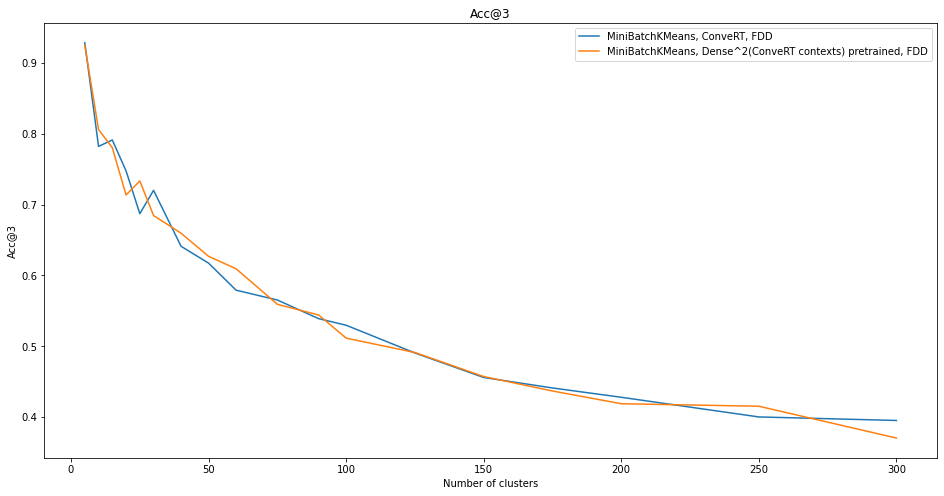

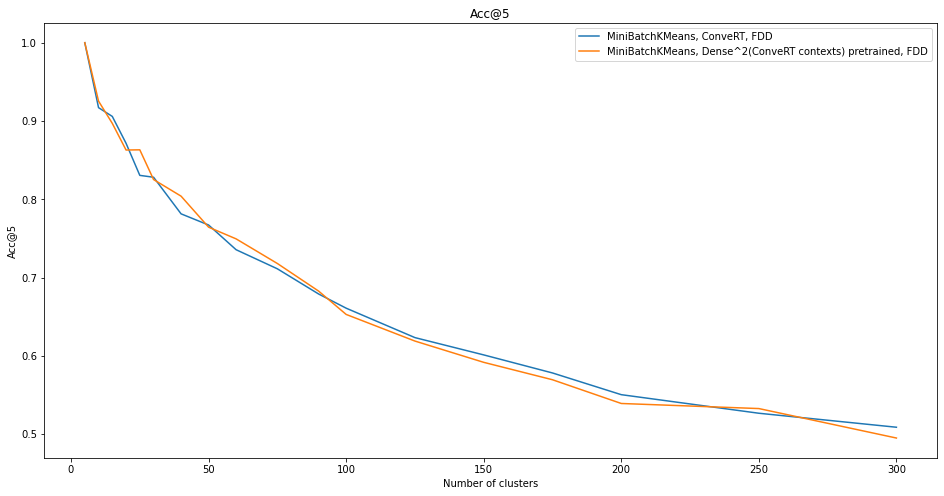

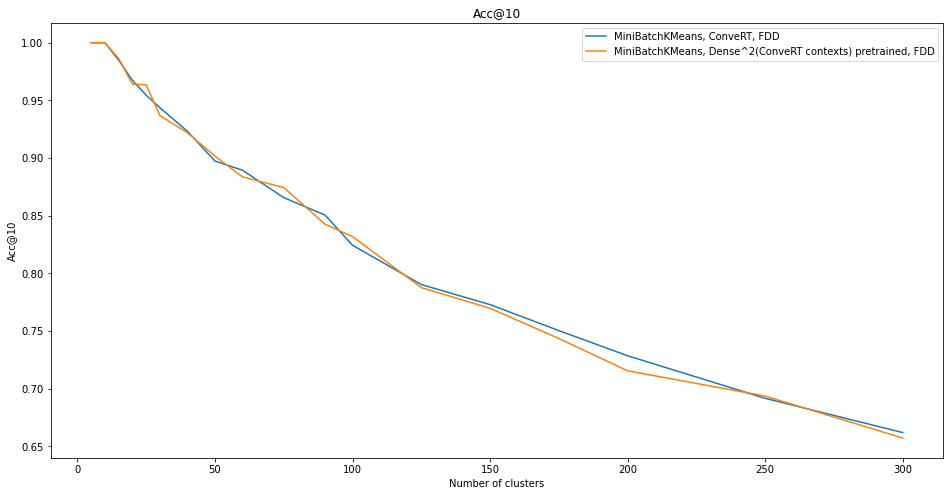

In [34]:
accuracy_multiplot([anal_baseline, anal_pretrained], 3)
accuracy_multiplot([anal_baseline, anal_pretrained], 5)
accuracy_multiplot([anal_baseline, anal_pretrained], 10)

In [111]:
#torch.save(model.state_dict(), "pretrained_dense_pair.torch")

In [53]:
model.load_state_dict(torch.load("pretrained_dense_pair.torch"))

<All keys matched successfully>

## Train (@_@)

In [35]:
# Step 1: prepare to columns of indexes
requests = []
replies = []
for dialog in train:
    start = train.get_dialog_start_idx(dialog)
    indexes = list(range(start, start+len(dialog)))
    requests += indexes[:-1]
    replies += indexes[1:]
requests = torch.tensor(requests).to(device)
replies = torch.tensor(replies).to(device)

In [84]:
def train_model(model, optimizer, inputs, requests, replies, cluster_count, clustering=MiniBatchKMeansClustering, losses=None, freqlosses=None, n_epochs=100, n_epochs2=10, batch_size=128):
    for epoch in tqdm(range(n_epochs)):
    
        # Clustering
        current_embedding = model(inputs).detach().cpu().numpy()
        current_clustering = clustering(cluster_count).fit(current_embedding)
        
        # Calculating frequencies in place
        freqs = np.zeros((cluster_count, cluster_count))
        cluster_idx = []
        for i,j in zip(requests,replies):
            freqs[current_clustering.get_utterance_cluster(i).id,current_clustering.get_utterance_cluster(j).id]+=1
            cluster_idx.append(current_clustering.get_utterance_cluster(i).id)
        
        # Selecting maximums
        freqs = np.array([np.array(freqs[v]) / np.sum(freqs[v]) for v in range(cluster_count)])
        if freqlosses is not None:
            freqlosses.append(np.mean(np.max(freqs, axis=1)))
        freqs = np.argmax(freqs, axis=1)
        
        
        # Torching
        freqs = torch.tensor(freqs, dtype=torch.long).to(device)
        cluster_idx = torch.tensor(cluster_idx, dtype=torch.long).to(device)
        centers = torch.tensor(current_clustering.clustering.cluster_centers_, dtype=torch.long).to(device)
        
        # Second loop
        for epoch2 in range(n_epochs2):
            permutation = torch.randperm(requests.size()[0])
            loss_total = 0
            for i in range(0,requests.size()[0], batch_size):
                optimizer.zero_grad()
                indices_req = permutation[i:i+batch_size]
                indices_repl = replies[permutation[i:i+batch_size]]
                repls = inputs[indices_repl]
                outputs = model.forward(repls)
                req_clusters = cluster_idx[indices_req]
                target_clusters = freqs[req_clusters]
                target_centers = centers[target_clusters]
                
                loss = (outputs - target_centers).abs().sum()
                
                loss_total += loss.detach().cpu().item()
                loss.backward()
                optimizer.step()
            if losses is not None:
                losses.append(loss_total)

In [98]:
losses, freqlosses=[],[]

In [52]:
optimizer = optim.Adam(model.parameters(), lr=0.000000001)
train_model(model, optimizer, torch_context_train, requests, replies, 10, losses=losses, freqlosses=freqlosses, n_epochs = 2500, n_epochs2=1)

NameError: name 'train_model' is not defined

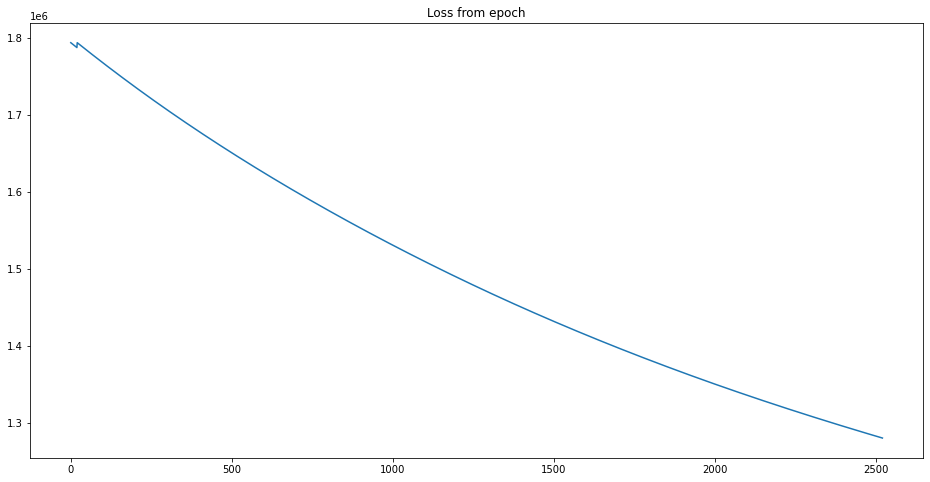

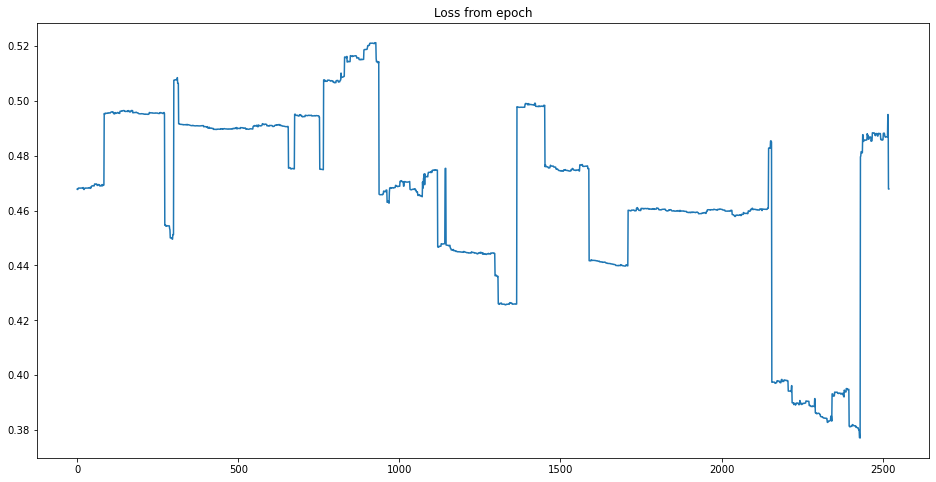

In [106]:
plot_loss(losses)
plot_loss(freqlosses)

In [47]:
densed_train = model(torch_context_train).cpu().detach().numpy()
densed_test = model(torch_context_test).cpu().detach().numpy()
densed_embedding = CachedEmbeddings(train, densed_train, test, densed_test)

In [48]:
anal_baseline = AccuracyAnalyzer("MiniBatchKMeans, ConveRT, FDD", cached_convert_context, train_convert, algo=MiniBatchKMeansClustering)
anal_baseline.build(cluster_counts_small)

anal_pretrained = AccuracyAnalyzer("MiniBatchKMeans, Dense^2(ConveRT contexts) pretrained, FDD", densed_embedding, densed_train, algo=MiniBatchKMeansClustering)
anal_pretrained.build(cluster_counts_small)

  0%|          | 0/4 [00:00<?, ?it/s]

5 (4.130727810374828, array([0.92864209, 1.        , 1.        ]))
10 (3.94510797817567, array([0.78221798, 0.91702162, 1.        ]))
25 (3.9688876180339183, array([0.68720141, 0.8305093 , 0.95445165]))
50 (3.5805064175365997, array([0.61735575, 0.76712314, 0.89737213]))


  0%|          | 0/4 [00:00<?, ?it/s]

5 (3.360293606966156, array([0.93401296, 1.        , 1.        ]))
10 (3.887016874039643, array([0.84823083, 0.94189468, 1.        ]))
25 (3.91494083506188, array([0.696437  , 0.81556791, 0.9348668 ]))
50 (3.58590902796505, array([0.5990215 , 0.75945355, 0.89028906]))


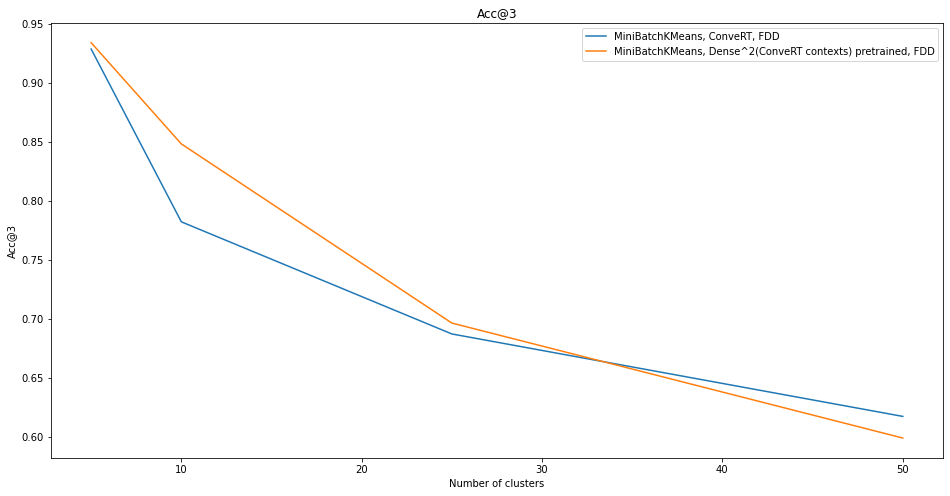

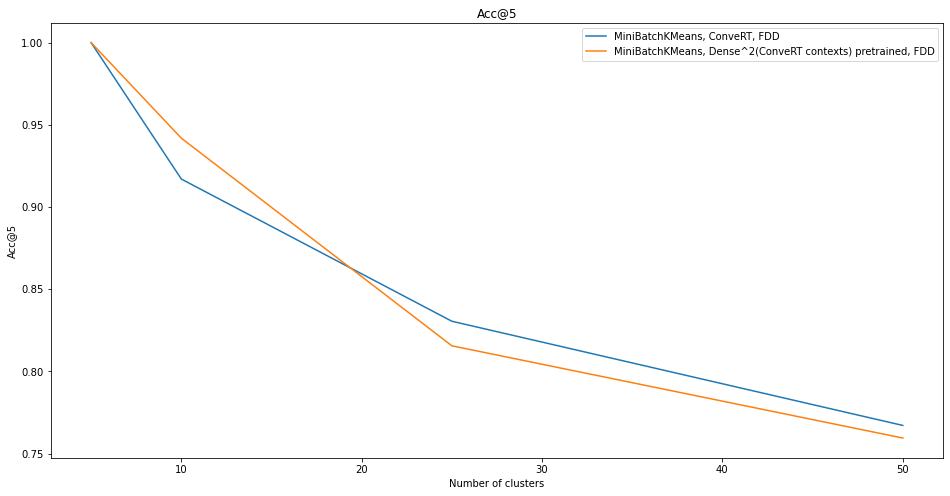

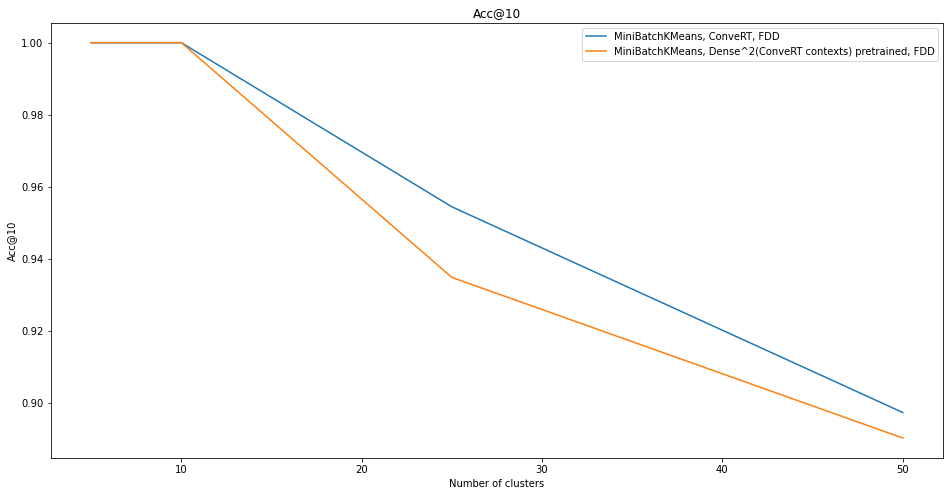

In [49]:
accuracy_multiplot([anal_baseline, anal_pretrained], 3)
accuracy_multiplot([anal_baseline, anal_pretrained], 5)
accuracy_multiplot([anal_baseline, anal_pretrained], 10)

In [112]:
#torch.save(model.state_dict(), "trained1_dense_pair.torch")

In [41]:
def train_model2(model, optimizer, inputs, requests, replies, cluster_count, losses=None, freqlosses=None, n_epochs=100, n_epochs2=10, batch_size=128):
    for epoch in tqdm(range(n_epochs)):    
        
        # Clustering
        current_embedding = model(inputs).detach().cpu().numpy()
        current_clustering = clustering(cluster_count).fit(current_embedding)
        
        # Calculating frequencies in place
        freqs = np.zeros((cluster_count, cluster_count))
        cluster_idx = []
        for i,j in zip(requests,replies):
            freqs[current_clustering.get_utterance_cluster(i).id,current_clustering.get_utterance_cluster(j).id]+=1
            cluster_idx.append(current_clustering.get_utterance_cluster(i).id)
        
        # Selecting maximums
        freqs = np.array([np.array(freqs[v]) / np.sum(freqs[v]) for v in range(cluster_count)])
        if freqlosses is not None:
            freqlosses.append(np.mean(np.max(freqs, axis=1)))
        ## -------------------------------
        
        permutation = torch.randperm(requests.size()[0])
        loss_total = 0
        for i in range(0,requests.size()[0], batch_size):
            optimizer.zero_grad()
            indices_req = requests[permutation[i:i+batch_size]]
            indices_repl = replies[permutation[i:i+batch_size]]
            
            reqs = model.forward(inputs[indices_req])
            repl = model.forward(inputs[indices_repl])
             
            loss = torch.sum(torch.abs(torch.abs(reqs[1:] - reqs[:-1]) - torch.abs(repl[1:] - repl[:-1])))
                
            loss_total += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
        if losses is not None:
            losses.append(loss_total)

In [55]:
losses, freqlosses=[],[]

In [56]:
optimizer = optim.Adam(model.parameters(), lr=0.000000001)
train_model2(model, optimizer, torch_context_train, requests, replies, 100, losses=losses, freqlosses=freqlosses, n_epochs = 2500, n_epochs2=1)

  0%|          | 0/2500 [00:00<?, ?it/s]

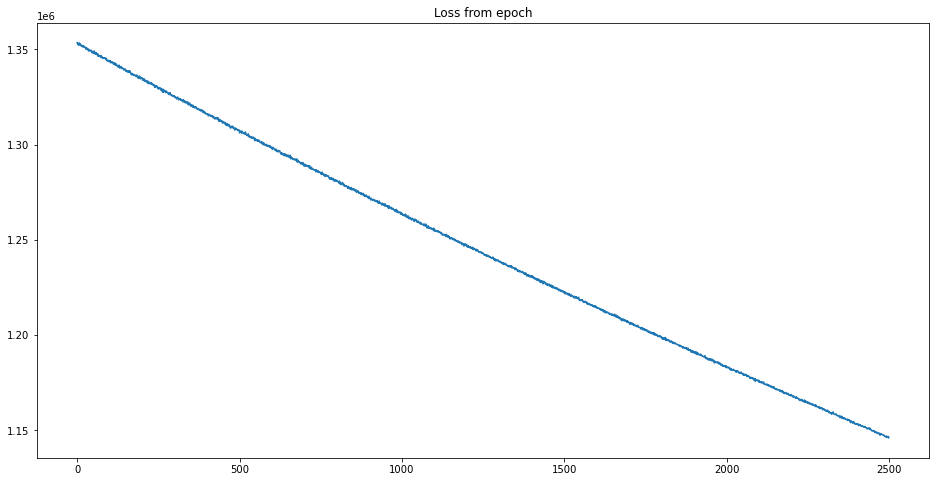

In [46]:
plot_loss(losses)

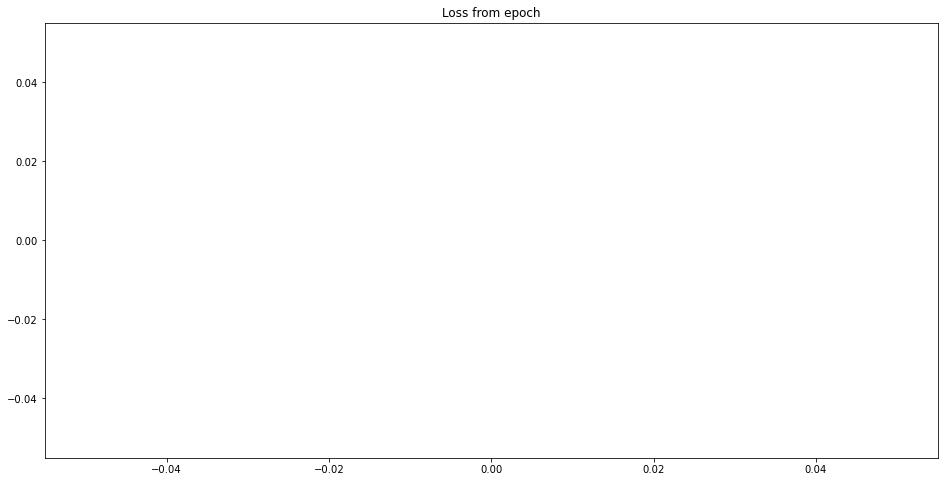

In [58]:
plot_loss(freqlosses)

# Future clustering

In [5]:
# Loading convert
test_convert = np.load("test_convert_context.np.npy")
resp_test_convert = np.load("test_convert_responses.np.npy")

train_convert = np.load("train_convert_context.np.npy")
resp_train_convert = np.load("train_convert_responses.np.npy")

cached_convert_context = CachedEmbeddings(train, train_convert, test, test_convert)
cached_convert_response = CachedEmbeddings(train, resp_train_convert, test, resp_test_convert)

# Step 1: prepare to columns of indexes
requests = []
replies = []
for dialog in train:
    start = train.get_dialog_start_idx(dialog)
    indexes = list(range(start, start+len(dialog)))
    requests += indexes[:-1]
    replies += indexes[1:]

## Edge end prediction

In [6]:
class IEndPredictor:
    def __init__(self):
        pass
    def forward(self, nodes):
        pass

class HookEndPredictor:
    def forward(self, nodes):
        return nodes
    
class ZeroEndPredictor:
    def forward(self, nodes):
        return np.zeros_like(nodes)

## Experiments

In [223]:
def get_train_score(gold_embedding, embedding, dataset, clustering, cluster_count):
    # Clustering
    current_embedding = gold_embedding
    current_clustering = clustering(cluster_count).fit(current_embedding)
    # Getting embedding scores
    labels = current_clustering.clustering.predict(embedding)
        
    # Calculating frequencies in place
    freqs = np.zeros((cluster_count, cluster_count))
    for dialog in dataset:
        start = dataset.get_dialog_start_idx(dialog)
        for i in range(start, start+len(dialog) - 1):
            freqs[labels[i], labels[i+1]] += 1
    return np.sum(np.max(freqs, axis=1)) / np.sum(freqs)

def get_train_scores(gold_embedding, embedding, dataset, clustering, cluster_counts):
    return [get_train_score(gold_embedding, embedding, dataset, clustering, count) for count in tqdm(cluster_counts)]

In [240]:
def get_test_score(train_embedding, train_dataset, test_embedding, test_dataset, clustering, cluster_count, fdd_embedding = None):
    # Clustering
    current_embedding = train_embedding
    current_clustering = clustering(cluster_count).fit(current_embedding)
   
    
    # Getting embedding scores
    if fdd_embedding is not None:
        centers = current_clustering.clustering.cluster_centers_
        current_clustering = clustering(cluster_count)
        current_clustering.fit(fdd_embedding[:cluster_count+1])
        current_clustering.clustering.cluster_centers_ = np.ascontiguousarray(centers[:,:len(fdd_embedding[0])])
        labels = current_clustering.clustering.predict(fdd_embedding)
    else:
        labels = current_clustering.clustering.predict(train_embedding)

    # Calculating frequencies in place
    freqs = np.zeros((cluster_count, cluster_count))
    for dialog in train_dataset:
        start = train_dataset.get_dialog_start_idx(dialog)
        for i in range(start, start+len(dialog) - 1):
            freqs[labels[i], labels[i+1]] += 1
    
    # Argsorting
    freqs = np.argsort(freqs)[:,::-1]
    freqs2 = np.zeros_like(freqs)
    
    # Evaluating
    result = 0.0
    total = 0.0
    labels = current_clustering.clustering.predict(test_embedding)
    for dialog in test_dataset:
        start = test_dataset.get_dialog_start_idx(dialog)
        for i in range(start, start+len(dialog) - 1):
            total += 1
            if freqs[labels[i],  0] == labels[i+1]:
                freqs2[labels[i], labels[i+1]] += 1
                result += 1
    return result / total
    

def get_test_scores(train_embedding, train_dataset, test_embedding, test_dataset, clustering, cluster_counts, fdd_embedding = None):
    return [get_test_score(train_embedding, train_dataset, test_embedding, test_dataset, clustering, count, fdd_embedding) for count in tqdm(cluster_counts)]

In [169]:
naive_scores = get_train_scores(train_convert, train_convert, train, MiniBatchKMeansClustering, cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

In [170]:
import matplotlib.pyplot as plt

def plot_scores(counts, scores, title):
    plt.figure(figsize=(16,8))
    for label, scores in scores.items():
        plt.plot(counts, scores[:len(counts)], label=label)
    plt.legend()
    plt.title(title)
    plt.xlabel("Число кластеров")
    plt.show()

In [196]:
def build_futured_embedding(embedding, dataset):
    new_embedding = np.concatenate((embedding, embedding), axis=1)
    for dialog in dataset:
        start = dataset.get_dialog_start_idx(dialog)
        for i in range(start, start+len(dialog) - 1):
            new_embedding[i] = np.concatenate((embedding[i], embedding[i+1]))
    return new_embedding
    

In [197]:
new_embedding = build_futured_embedding(train_convert, train)

In [171]:
future_scores = get_train_scores(new_embedding,new_embedding, train, MiniBatchKMeansClustering, cluster_counts )

  0%|          | 0/18 [00:00<?, ?it/s]

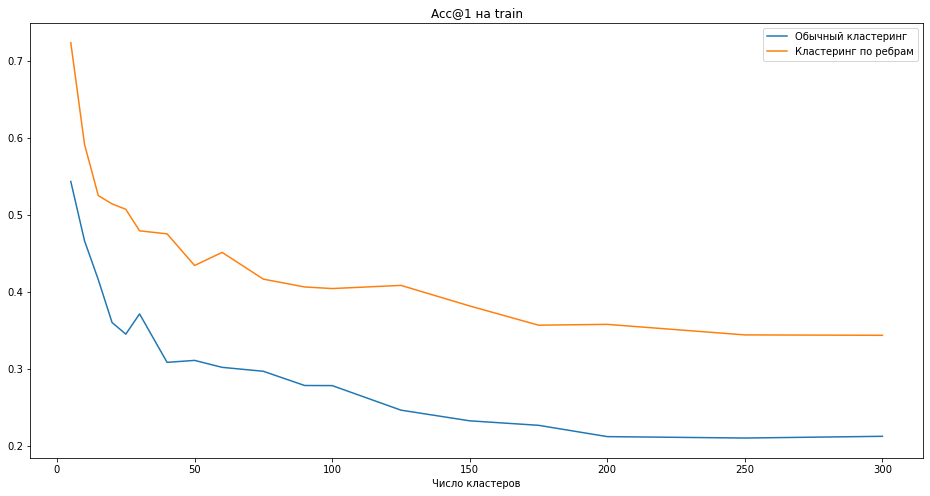

In [172]:
plot_scores(cluster_counts, {'Обычный кластеринг':naive_scores, 'Кластеринг по ребрам': future_scores}, "Acc@1 на train")

**Вывод:** кластеринг по ребрам реально повышает метрики

**Прооблема:** на тесте мы не знаем куда идет ребро

In [33]:
def build_gold_clusterings(gold_embedding, clustering, cluster_counts):
    result = []
    for cluster_count in tqdm(cluster_counts):
        current_embedding = gold_embedding
        current_clustering = clustering(cluster_count).fit(current_embedding)
        result.append(current_clustering)
    return result

def get_cluster_score(gold_embedding, embedding, current_clustering):
    return (current_clustering.clustering.predict(gold_embedding) == (current_clustering.clustering.predict(embedding))).mean()

def get_cluster_scores(predictor, gold_embedding, embedding, current_clusterings):
    return [get_cluster_score(gold_embedding, np.concatenate((embedding,predictor.forward(embedding)), axis=1), clustering) for clustering in tqdm(current_clusterings)]

In [34]:
clusterings = build_gold_clusterings(new_embedding, MiniBatchKMeansClustering, cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

In [39]:
hook_clscores = get_cluster_scores(HookEndPredictor(), new_embedding, train_convert, clusterings) 

  0%|          | 0/18 [00:00<?, ?it/s]

In [40]:
zero_clscores = get_cluster_scores(ZeroEndPredictor(), new_embedding, train_convert, clusterings) 

  0%|          | 0/18 [00:00<?, ?it/s]

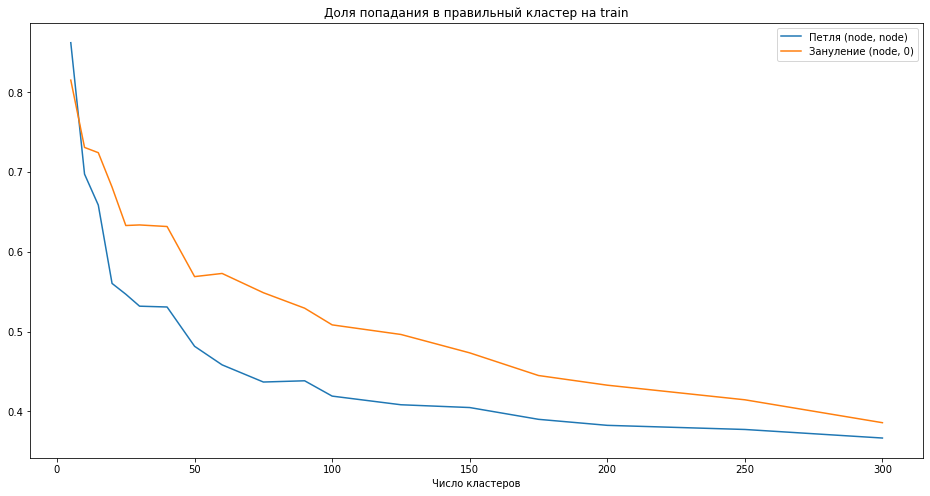

In [41]:
plot_scores(cluster_counts, {'Петля (node, node)':hook_clscores, 'Зануление (node, 0)':zero_clscores}, "Доля попадания в правильный кластер на train")

future_scores = get_train_scores(new_embedding,new_embedding, requests, replies, MiniBatchKMeansClustering, cluster_counts )**Вывод:** лучше занулять, пространство для работы есть, дисперсия внутри теста (отдельно проверена) невелика, можно отреззать кусок
для валидации

## Future train scoring

In [206]:
future_scores_zeroed = get_train_scores(new_embedding,np.concatenate((train_convert, ZeroEndPredictor().forward(train_convert)),axis=1), train, MiniBatchKMeansClustering, cluster_counts )

  0%|          | 0/18 [00:00<?, ?it/s]

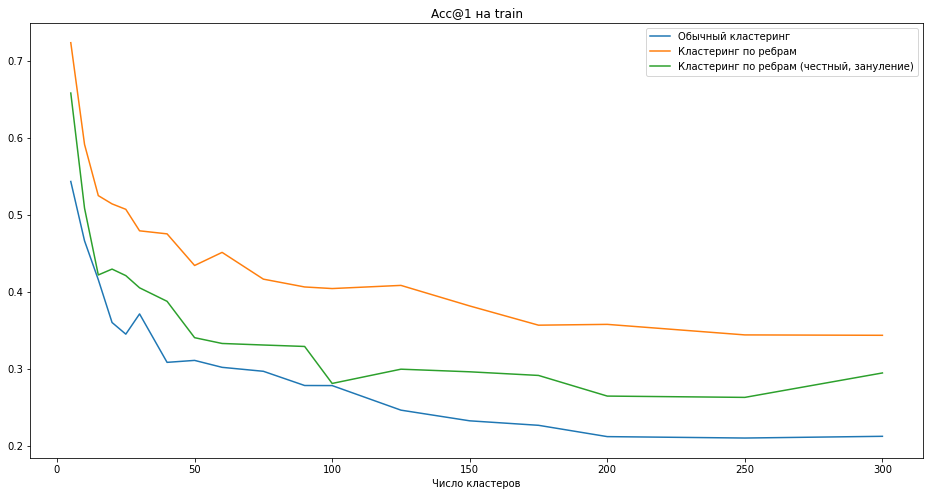

In [207]:
plot_scores(cluster_counts, {'Обычный кластеринг':naive_scores, 'Кластеринг по ребрам': future_scores, 'Кластеринг по ребрам (честный, зануление)':future_scores_zeroed}, "Acc@1 на train")

## Future test evaluation

**Посмотрим на то насколько хорош граф по тесту**

In [175]:
embedding_test = np.concatenate((test_convert, ZeroEndPredictor().forward(test_convert)), axis=1)

In [202]:
future_scores_test = get_train_scores(new_embedding, embedding_test, test, MiniBatchKMeansClustering, cluster_counts )

  0%|          | 0/18 [00:00<?, ?it/s]

In [203]:
scores_test = get_train_scores(train_convert, test_convert, test, MiniBatchKMeansClustering, cluster_counts )

  0%|          | 0/18 [00:00<?, ?it/s]

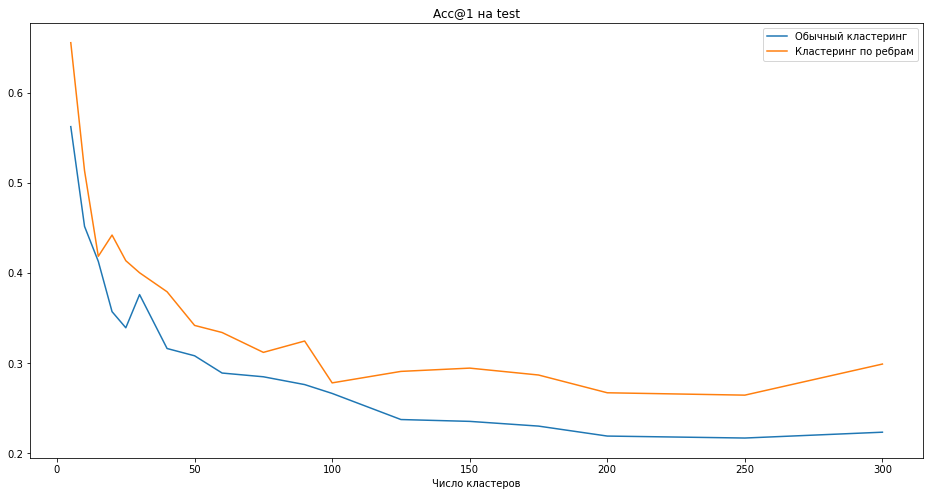

In [204]:
plot_scores(cluster_counts, {'Обычный кластеринг':scores_test, 'Кластеринг по ребрам': future_scores_test}, "Acc@1 на test")

**Посмотрима на качество графа трейна но с эксплойтом ребер теста**

In [181]:
scores_test_honest = get_test_scores(train_convert, train, test_convert, test, MiniBatchKMeansClustering, cluster_counts )

  0%|          | 0/18 [00:00<?, ?it/s]

In [182]:
future_scores_test_honest = get_test_scores(new_embedding, train, embedding_test, test, MiniBatchKMeansClustering, cluster_counts )

  0%|          | 0/18 [00:00<?, ?it/s]

In [198]:
future_scores_test_exploit = get_test_scores(new_embedding, train, build_futured_embedding(test_convert, test), test, MiniBatchKMeansClustering, cluster_counts )

  0%|          | 0/18 [00:00<?, ?it/s]

In [210]:
future_scores_test_fddzero = get_test_scores(new_embedding, train, embedding_test, test, MiniBatchKMeansClustering, cluster_counts, np.concatenate((train_convert, np.zeros_like(train_convert)), axis=1) )

  0%|          | 0/18 [00:00<?, ?it/s]

In [241]:
## Fully ignore endings...
future_scores_test_fddignored = get_test_scores(new_embedding, train, test_convert, test, MiniBatchKMeansClustering, cluster_counts, fdd_embedding=train_convert)

  0%|          | 0/18 [00:00<?, ?it/s]

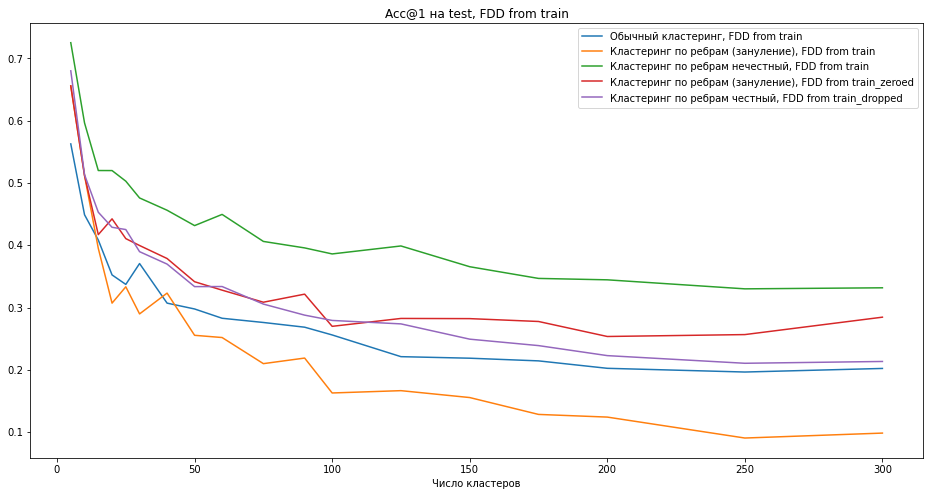

In [243]:
plot_scores(cluster_counts, {'Обычный кластеринг, FDD from train':scores_test_honest, 'Кластеринг по ребрам (зануление), FDD from train': future_scores_test_honest, "Кластеринг по ребрам нечестный, FDD from train":future_scores_test_exploit, "Кластеринг по ребрам (зануление), FDD from train_zeroed": future_scores_test_fddzero, "Кластеринг по ребрам честный, FDD from train_dropped":future_scores_test_fddignored}, "Acc@1 на test, FDD from train")

## Model training

In [245]:
import torch
import torch.nn as nn
import torch.optim as optim

In [246]:
device = 'cuda'

In [253]:
from IPython.display import clear_output

def create_dense(size=512, device=0):
    return nn.Sequential(nn.Linear(size,size),nn.ReLU(size),nn.Linear(size,size)).to(device)

def train_model(model, optimizer, lossfunction, X, Y, losses=None, n_epochs=100, batch_size=128):
    for epoch in tqdm(range(n_epochs)):
        permutation = torch.randperm(X.size()[0])
        epoch_loss = 0
        for i in range(0,X.size()[0], batch_size):
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], Y[indices]

            # in case you wanted a semi-full example
            outputs = model.forward(batch_x)
            loss = lossfunction(outputs,batch_y)
            epoch_loss += loss.cpu().item()

            loss.backward()
            optimizer.step()
        if losses is not None:
            losses.append(epoch_loss / len(X))
        
        clear_output()
        plot_loss(losses)
            
def plot_loss(losses):
    plt.figure(figsize=(16,8))
    plt.plot(range(len(losses)), losses)
    plt.title("Loss from epoch")
    plt.show()

In [266]:
model = nn.Sequential(nn.Linear(512, 512),nn.ReLU(512),nn.Linear(512,512),nn.ReLU(512),nn.Linear(512,512)).to(device)
X = torch.tensor(new_embedding[:,:512]).to(device)
Y = torch.tensor(new_embedding[:,512:]).to(device)
losses = []

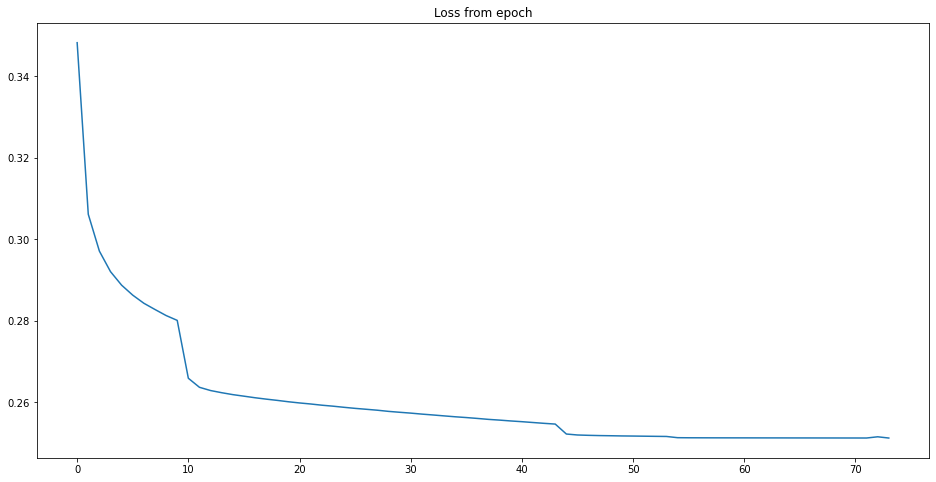

In [270]:
lossfunction = lambda y_pred, y_target: ((y_pred-y_target)**2).sum()

optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_model(model, optimizer, lossfunction, X, Y, losses, n_epochs=1)

optimizer = optim.Adam(model.parameters(), lr=0.000001)
train_model(model, optimizer, lossfunction, X, Y, losses, n_epochs=1)

In [273]:
future_scores_test_model = get_test_scores(new_embedding, train, np.concatenate((test_convert, model.forward(torch.tensor(test_convert).to(device)).cpu().detach().numpy()), axis=1), test, MiniBatchKMeansClustering, cluster_counts, np.concatenate((train_convert, model.forward(torch.tensor(train_convert).to(device)).cpu().detach().numpy()), axis=1) )

  0%|          | 0/18 [00:00<?, ?it/s]

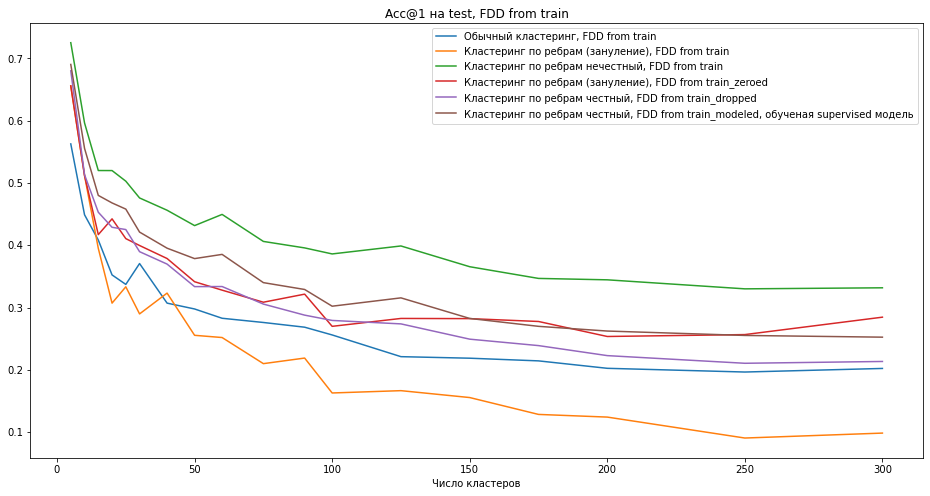

In [274]:
plot_scores(cluster_counts, {'Обычный кластеринг, FDD from train':scores_test_honest, 'Кластеринг по ребрам (зануление), FDD from train': future_scores_test_honest, "Кластеринг по ребрам нечестный, FDD from train":future_scores_test_exploit, "Кластеринг по ребрам (зануление), FDD from train_zeroed": future_scores_test_fddzero, "Кластеринг по ребрам честный, FDD from train_dropped":future_scores_test_fddignored,"Кластеринг по ребрам честный, FDD from train_modeled, обученая supervised модель":future_scores_test_model}, "Acc@1 на test, FDD from train")

In [283]:
anal_baseline = AccuracyAnalyzer("MiniBatchKMeans (basic), ConveRT, FDD", cached_convert_context, train_convert, algo=MiniBatchKMeansClustering)
anal_baseline.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (4.130727810374828, array([0.57697465, 0.92864209, 1.        , 1.        ]))
10 (3.94510797817567, array([0.48160081, 0.78221798, 0.91702162, 1.        ]))
15 (4.1782340988807345, array([0.44005224, 0.79125866, 0.90582383, 0.98482174]))
20 (4.194436618243271, array([0.36361657, 0.7476943 , 0.87150767, 0.96741801]))
25 (3.9688876180339183, array([0.35919532, 0.68720141, 0.8305093 , 0.95445165]))
30 (3.9301740681403885, array([0.38256272, 0.72014363, 0.82815444, 0.94354512]))
40 (3.6681579453159707, array([0.33391014, 0.64115564, 0.78138573, 0.92321432]))
50 (3.5805064175365997, array([0.30227249, 0.61735575, 0.76712314, 0.89737213]))
60 (3.5025921808896006, array([0.28693318, 0.57918093, 0.73556265, 0.88938955]))
75 (3.3926846728529054, array([0.27890582, 0.56531459, 0.71117473, 0.86565306]))
90 (3.3014701155290793, array([0.26300182, 0.53899333, 0.67898652, 0.85054903]))
100 (3.1966777901069623, array([0.25847546, 0.5296881 , 0.66089103, 0.82435273]))
125 (3.001972491657565, array([0

In [284]:
anal_futured_z = AccuracyAnalyzer("MiniBatchKMeans (futured [+zero]), ConveRT, FDD", CachedEmbeddings(train, np.concatenate((train_convert, np.zeros_like(train_convert)), axis=1), test, embedding_test), new_embedding, algo=MiniBatchKMeansClustering)
anal_futured_z.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (3.6423628269110173, array([0.65808936, 0.90617218, 1.        , 1.        ]))
10 (4.274354211421074, array([0.50835825, 0.81749198, 0.91781595, 1.        ]))
15 (4.217665238544964, array([0.43149539, 0.77012443, 0.88529133, 0.9842686 ]))
20 (4.082988883396307, array([0.45485633, 0.75637706, 0.87243831, 0.97081545]))
25 (3.9215159308101852, array([0.41710373, 0.73201161, 0.86090937, 0.96175955]))


/data/home/admin/dialog-graph-construction/notebooks/dialog_imports.py:302: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])


30 (3.881736724574206, array([0.40487957, 0.70151662, 0.83357171, 0.95263945]))
40 (3.776473377923497, array([0.38487137, 0.67914062, 0.79976446, 0.93104838]))


/data/home/admin/dialog-graph-construction/notebooks/dialog_imports.py:302: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])


50 (3.632603736092674, array([0.3474607 , 0.63599027, 0.77278218, 0.89842824]))


/data/home/admin/dialog-graph-construction/notebooks/dialog_imports.py:302: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])


60 (3.571889996720767, array([0.32290898, 0.6244576 , 0.75474593, 0.89160371]))


/data/home/admin/dialog-graph-construction/notebooks/dialog_imports.py:302: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])


75 (3.390896397615846, array([0.30760999, 0.5885299 , 0.72221622, 0.87387341]))


/data/home/admin/dialog-graph-construction/notebooks/dialog_imports.py:302: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])


90 (nan, array([0.32980971, 0.59430476, 0.71933652, 0.8706653 ]))


/data/home/admin/dialog-graph-construction/notebooks/dialog_imports.py:302: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])


100 (3.3486293096301365, array([0.2653137 , 0.5526964 , 0.68997255, 0.85280675]))


/data/home/admin/dialog-graph-construction/notebooks/dialog_imports.py:302: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])


125 (3.2402584340905656, array([0.29101646, 0.55256416, 0.68052804, 0.83007894]))


/data/home/admin/dialog-graph-construction/notebooks/dialog_imports.py:302: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])


150 (3.160930690951828, array([0.27999111, 0.53647345, 0.66394241, 0.81706353]))


/data/home/admin/dialog-graph-construction/notebooks/dialog_imports.py:302: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])


175 (3.0735032951796915, array([0.27589141, 0.52098005, 0.64009938, 0.80246167]))


/data/home/admin/dialog-graph-construction/notebooks/dialog_imports.py:302: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])


200 (nan, array([0.2565551 , 0.51005253, 0.63902756, 0.79932492]))


/data/home/admin/dialog-graph-construction/notebooks/dialog_imports.py:302: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])


250 (2.8713255489056175, array([0.25289673, 0.48302537, 0.61418971, 0.76913351]))


/data/home/admin/dialog-graph-construction/notebooks/dialog_imports.py:302: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = [np.array(self.edges[v]) / np.sum(self.edges[v])


300 (nan, array([0.28366934, 0.49689418, 0.60804362, 0.75739971]))


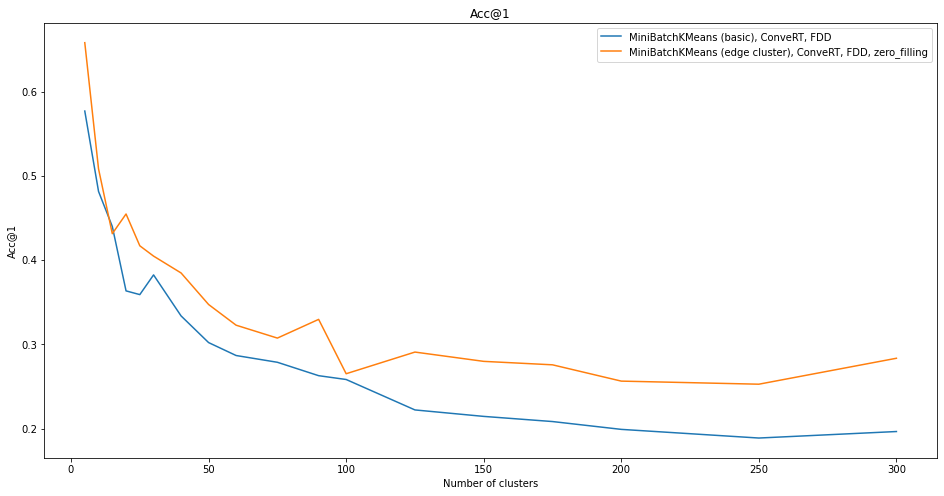

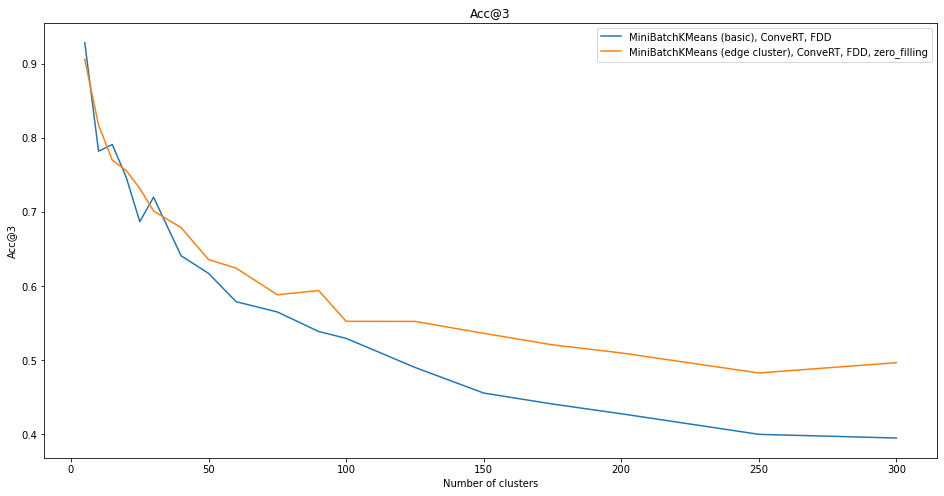

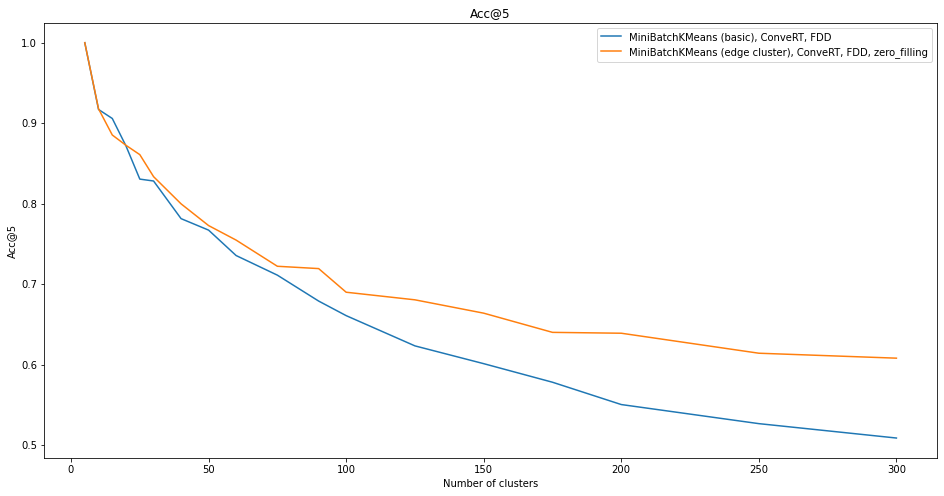

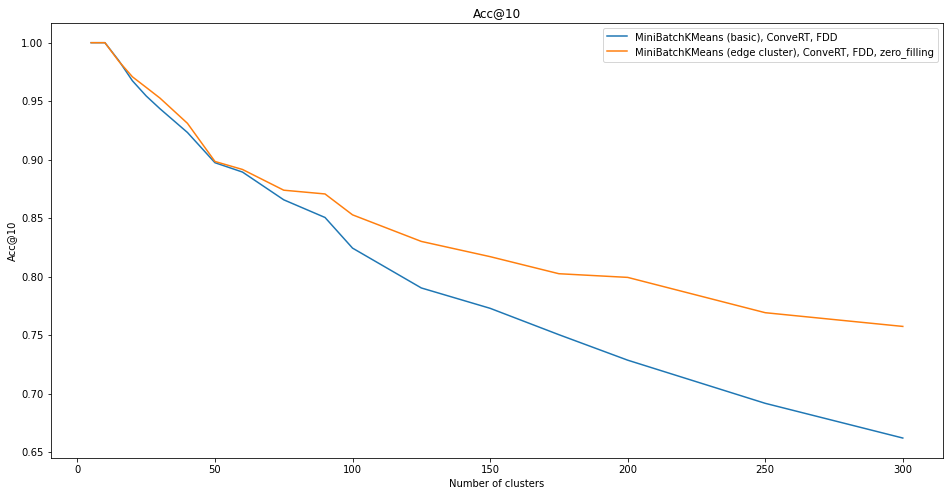

In [289]:
anal_futured_z.name = "MiniBatchKMeans (edge cluster), ConveRT, FDD, zero_filling"
accuracy_multiplot([anal_baseline, anal_futured_z], 1)
accuracy_multiplot([anal_baseline, anal_futured_z], 3)
accuracy_multiplot([anal_baseline, anal_futured_z], 5)
accuracy_multiplot([anal_baseline, anal_futured_z], 10)

In [ ]:
anal_baseline1 = AccuracyAnalyzer("KMeans (basic), ConveRT, FDD", cached_convert_context, train_convert, algo=KMeansClustering)
anal_baseline1.build(cluster_counts)
anal_futured_z1 = AccuracyAnalyzer("KMeans (futured [+zero]), ConveRT, FDD", CachedEmbeddings(train, np.concatenate((train_convert, np.zeros_like(train_convert)), axis=1), test, embedding_test), new_embedding, algo=KMeansClustering)
anal_futured_z1.build(cluster_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

5 (3.726898988837948, array([0.63352659, 0.9371173 , 1.        , 1.        ]))
10 (4.103061147528825, array([0.50781996, 0.82883295, 0.92979485, 1.        ]))
15 (4.21707414609265, array([0.43435055, 0.77776946, 0.89189008, 0.98559882]))
20 (4.063403182787195, array([0.42676067, 0.76423958, 0.88112851, 0.97127093]))
25 (4.036868620791753, array([0.42145931, 0.7535412 , 0.85868227, 0.96024911]))
30 (3.935993593014438, array([0.38556926, 0.71083141, 0.83401078, 0.94979332]))
40 (3.86545911920928, array([0.33063823, 0.67704584, 0.81882473, 0.93575936]))
50 (3.7059738616621316, array([0.32516996, 0.64492678, 0.79072302, 0.90699732]))
60 (3.59510011990211, array([0.28676493, 0.6178239 , 0.75843016, 0.89059005]))
75 (3.471314759776819, array([0.29080668, 0.57682569, 0.71599985, 0.87283699]))
90 (3.3409899953457955, array([0.25942774, 0.55116021, 0.69796011, 0.86287099]))
100 (3.2350430240513997, array([0.25257453, 0.52272776, 0.66685667, 0.84137997]))
125 (3.0841179434703565, array([0.234260

In [ ]:
anal_futured_z.name = "MiniBatchKMeans (edge cluster), ConveRT, FDD, zero_filling"
accuracy_multiplot([anal_baseline1, anal_futured_z1], 1)
accuracy_multiplot([anal_baseline1, anal_futured_z1], 3)
accuracy_multiplot([anal_baseline1, anal_futured_z1], 5)
accuracy_multiplot([anal_baseline1, anal_futured_z1], 10)

### Merge

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm, trange
from IPython.display import clear_output


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def construct_dataset(clusters_data, n_neighbours=2, n_clusters=200):
    x = []
    y = []
    for dialogue in clusters_data:
        for center in range(len(dialogue)):
            ohe = np.zeros(n_clusters)
            for i in range(max(0, center - n_neighbours), 
                           min(center + n_neighbours + 1, len(dialogue))):
                if i != center:
                    ohe[dialogue[i]] = 1
            x.append(dialogue[center])
            y.append(ohe)
    return x, np.stack(y, axis=0)


def get_w2v_model(n_tokens, hid_size=32):
    return nn.Sequential(
        nn.Embedding(n_tokens, hid_size),
        nn.Linear(hid_size, n_tokens)
    )


def train_model(model, optimizer, criterion, log, train_loader, val_loader,
                n_epochs=40, plot_every=2, patience=3, continue_from=0):
    stop_count = 0

    for epoch in trange(continue_from, n_epochs):
        train_losses = []
        for x, y in tqdm(train_loader, leave=False):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
        log['train_loss'].append(np.mean(train_losses))

        with torch.no_grad():
            losses = []
            for x, y in tqdm(val_loader, leave=False):
                x = x.to(device)
                y = y.to(device)

                preds = model(x)
                loss = criterion(preds, y)
                losses.append(loss.item())
            log['val_loss'].append(np.mean(losses))

        if epoch % plot_every == 0:
            clear_output(True)
            plt.figure(figsize=(12, 8))
            plt.grid(True)
            plt.plot(log['train_loss'], label='train')
            plt.plot(log['val_loss'], label='val')
            plt.title('Cluster2Vec training')
            plt.show()

        if len(log['val_loss']) > 1 and log['val_loss'][-1] > log['val_loss'][-2]:
            stop_count += 1
            if stop_count >= patience:
                break
        else:
            stop_count = 0


def train_cluster_embeddings(train, val, embedder, clustering, n_neighbours=2, 
                             batch_size=64, device=device, hidden_size=8, **train_kwargs):
    train_clusters = encode_train_with_clusters(train, clustering)
    val_clusters = encode_test_with_clusters(val, embedder, clustering)
    
    X_train, y_train = construct_dataset(train_clusters, n_neighbours=n_neighbours, 
                                         n_clusters=clustering.get_nclusters())
    X_val, y_val = construct_dataset(val_clusters, n_neighbours=n_neighbours, 
                                     n_clusters=clustering.get_nclusters())
    
    train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = get_w2v_model(clustering.get_nclusters(), hid_size=hidden_size).to(device)

    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    log = {
        'train_loss': [],
        'val_loss': []
    }
    
    train_model(model, optimizer, criterion, log, train_loader, val_loader, **train_kwargs)
    
    cluster_embeddings = list(model.children())[0].weight.detach().cpu().numpy()
    
    return cluster_embeddings

In [23]:
from collections import defaultdict
from sklearn.cluster import KMeans

def merge_clusters_with_sep(cluster_embeddings, separator, clustering, dialogues, n_clusters=15):
    groups = defaultdict(list)
    for cluster in range(clustering.get_nclusters()):
        utt_idx = clustering.get_cluster(cluster).utterances[0]
        utt = dialogues.get_utterance_by_idx(utt_idx)
        dialogue = train.get_dialogue_by_idx(utt_idx)
        groups[separator(utt, dialogue)].append(cluster)
    
    labels = np.zeros(clustering.get_nclusters(), dtype=int)
    shift = 0
    for group, clusters in groups.items():
        local_embeddings = cluster_embeddings[clusters]
        cluster_kmeans = KMeans(n_clusters=n_clusters).fit(local_embeddings)
        for cluster_id, local_lab in zip(clusters, cluster_kmeans.labels_):
            labels[cluster_id] = local_lab + shift
        shift += n_clusters
        
    return labels

In [24]:
from sklearn.cluster import KMeans

def merge_clusters(cluster_embeddings, n_clusters=15):
    cluster_kmeans = KMeans(n_clusters=n_clusters).fit(cluster_embeddings)
    return cluster_kmeans.labels_

In [25]:
from collections import defaultdict

def separate_clusters(cluster_labels, separator, clustering, dialogues):
    groups = {}
    for cluster, cluster_label in enumerate(cluster_labels):
        utt_idx = clustering.get_cluster(cluster).utterances[0]
        utt = dialogues.get_utterance_by_idx(utt_idx)
        dialogue = train.get_dialogue_by_idx(utt_idx)
        if cluster_label not in groups:
            groups[cluster_label] = defaultdict(list)
        groups[cluster_label][separator(utt, dialogue)].append(cluster)
    
    new_labels = np.zeros_like(cluster_labels)
    cluster_idx = 0
    for dd in groups.values():
        for cluster in dd.values():
            for item in cluster:
                new_labels[item] = cluster_idx
            cluster_idx += 1
    return new_labels

In [26]:
from sklearn.manifold import TSNE

def plot_merge_clustering(cluster_embeddings, merge_labels):
    clusters_tsne = TSNE().fit_transform(cluster_embeddings)
    
    plt.figure(figsize=(15, 10))

    x, y = clusters_tsne.T
    plt.scatter(x, y, c=merge_labels)

    plt.show()

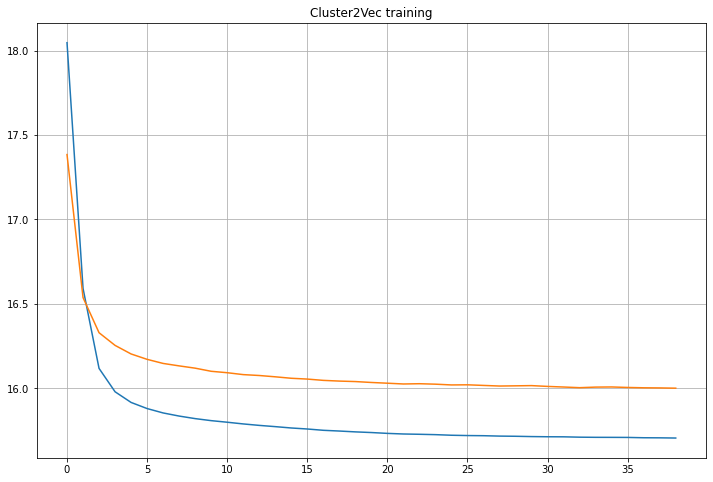

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

In [98]:
cluster_embeddings_se_sep_100 = train_cluster_embeddings(train, val, sentence_emb, clustering_se_sep_100)

In [101]:
cluster_kmeans_15_labels = merge_clusters(cluster_embeddings_se_sep_100)

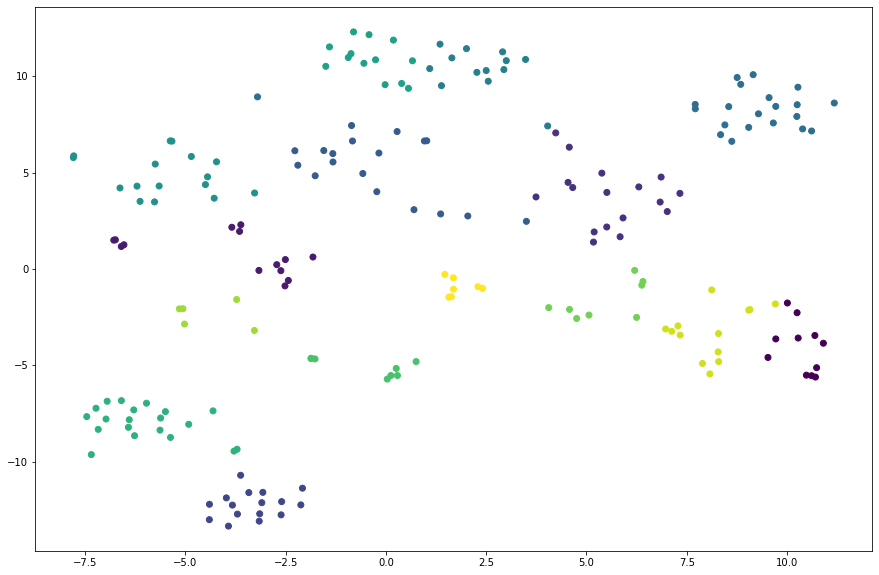

In [102]:
plot_merge_clustering(cluster_embeddings_se_sep_100, cluster_kmeans_15_labels)

In [57]:
for cluster_id in by_clusters[0]:
    cluster = clustering_se_sep_100.get_cluster(cluster_id)
    for utt in cluster.utterances[:5]:
        print(train.get_utterance_by_idx(utt))
    print('-' * 5)

Please book a table for 4 at the Chinese place at 12:30 on Sunday and give me the reference number.
that will be ok once you find the restaurant book a table for 6 people
That sounds great. I will need a table for 5.
That's fine. I'd like to know if it's in the centre of town. If so, I need a table for Sunday.
The Kohinoor sounds good. Could you book a table for 2 for me?
-----
I would like to book a table at the Backstreet Bistro for 5 people at 16:00 on Thursday.
That sounds like they'll have some awesome Chop Suey. Please book me a table for 2 on Tuesday at 12:45.
Yes, and can you book a table for 1 at 14:15 on Monday, please.
I would like to book a table for 5 people on Sunday at 14:15
Ok great. Can you reserve a table there for Thursday for 5 people at 15:00 please?
-----
I would prefer Italian but Indian would be good as well. I will need the phone number and postcode of the restaurant. Thanks!
Let's go with Italian food.
Hmm... let me think. Let's try maybe something italian ins

In [27]:
from copy import deepcopy
from collections import defaultdict

class MergeCluster(Cluster):
    def __init__(self, cluster_id, clusters):
        utterances = sum([cluster.utterances for cluster in clusters], [])
        super().__init__(cluster_id, utterances)
        self.clusters = clusters
    

class PrecomputedMergeClustering(OneViewClustering):
    def __init__(self, dialogues: DialogueDataset,
                 subclustering: OneViewClustering, 
                 merge_clustering_labels: np.ndarray):
        self.dialogues = dialogues
        self._subclustering = subclustering
        self._merge_clustering = merge_clustering_labels
        self.n_clusters = len(np.unique(merge_clustering_labels))
        
        self._by_clusters = defaultdict(list)
        for cluster, label in enumerate(merge_clustering_labels):
            self._by_clusters[label].append(cluster)
        
        self.clusters = []
        for label, cluster_ids in self._by_clusters.items():
            clusters = [self._subclustering.get_cluster(idx) for idx in cluster_ids]
            self.clusters.append(MergeCluster(label, clusters))
        
        self.fitted = True
        
    def fit(self, embeddings: np.array) -> 'SubClustering':
        pass
    
    def get_cluster(self, idx: int) -> Cluster:
        assert self.fitted, "Clustering must be fitted"
        
        return self.clusters[idx]

    def get_utterance_cluster(self, utterance_idx) -> Cluster:
        assert self.fitted, "Clustering must be fitted"
        
        cluster_id = self._subclustering.get_utterance_cluster(utterance_idx).id
        
        return self.clusters[self._merge_clustering[cluster_id]]
    
    def get_nclusters(self) -> int:
        return self.n_clusters
    
    def predict_cluster(self, embedding: np.array, 
                        utterance: tp.Optional[Utterance], 
                        dialogue: tp.Optional[Dialogue]):
        assert utterance is not None and dialogue is not None, \
            "Utterance and dialogue must be set for subclustering predictions"
        cluster_id = self._subclustering.predict_cluster(embedding, utterance, dialogue).id
        return self.clusters[self._merge_clustering[cluster_id]]
    
    def get_labels(self) -> np.array:
        labels = deepcopy(self._subclustering.get_labels())
        labels = np.array(list(map(lambda x: self._merge_clustering[int(x)], labels)), dtype=int)
        return labels

In [28]:
def build_graph(train, test, embedder, clustering, merge_labels):
    merged = PrecomputedMergeClustering(train, clustering, merge_labels)
    graph_merged = FrequencyDialogueGraph(train, embedder, merged)
    graph_merged._build()
    return graph_merged, graph_merged.success_rate(test, [3, 5, 10])

In [104]:
merged_se_15 = PrecomputedMergeClustering(train, clustering_se_sep_100, cluster_kmeans_15_labels)

In [90]:
graph_merged_se_sep_15 = FrequencyDialogueGraph(train, sentence_emb, merged_se_15)
graph_merged_se_sep_15._build()
graph_merged_se_sep_15.success_rate(test, [3, 5, 10])

(3.770707116383449, array([0.7364563 , 0.85894386, 0.97646853]))

In [117]:
score_se_sep_15

(3.8887419959587026, array([0.75160741, 0.85849382, 0.97992309]))

In [110]:
graph_merged_se_sep_15, scores = build_graph(train, test, 
                                             sentence_emb, 
                                             clustering_se_sep_100, 
                                             cluster_kmeans_15_labels)
scores

(4.005665258946167, array([0.74447982, 0.86334715, 0.97909731]))

In [29]:
def full_merge_build(train, val, test, embedder, clustering, n_clusters=15, separator=None, 
                     sep_before=True, n_neighbours=2, hidden_size=8):
    cluster_embeddings = train_cluster_embeddings(train, val, embedder, clustering, 
                                                  n_neighbours=n_neighbours, hidden_size=hidden_size)
    if separator is not None and sep_before:
        cluster_kmeans_labels = merge_clusters_with_sep(cluster_embeddings, 
                                                        separator, clustering, train,
                                                        n_clusters=n_clusters // 2)
    else:
        cluster_kmeans_labels = merge_clusters(cluster_embeddings, n_clusters=n_clusters)
        if separator is not None:
            cluster_kmeans_labels = separate_clusters(cluster_kmeans_labels, 
                                                      separator, clustering, train)
    plot_merge_clustering(cluster_embeddings, cluster_kmeans_labels)
    graph, scores = build_graph(train, test, embedder, 
                                clustering, cluster_kmeans_labels)
    return cluster_embeddings, cluster_kmeans_labels, graph, scores